<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Initial Setup

<style>
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>

## Mount drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Speech Folder Name

In [ ]:
snr = "0"
snr_str = str(snr).replace("-", "M")
snr_noise = str(snr).replace("MIX", "0")
snr_noise_str = snr_noise.replace("-", "M")
folder_name = f"TIMIT_{snr_str}_FINAL"

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Unzip file

In [3]:
import zipfile


zip_file_path =\
 f"/content/drive/MyDrive/TDTU/voice-processing/{folder_name}.zip"
extract_path = '/content/'


try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully unzipped {zip_file_path} to {extract_path}")
except FileNotFoundError:
  print(f"Error: File not found at {zip_file_path}")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully unzipped /content/drive/MyDrive/TDTU/voice-processing/TIMIT_0_FINAL.zip to /content/


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pickle
import IPython.display as ipd
import time
import random
random.seed(1)

from re import I

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
from torch import nn

from sklearn.metrics import auc


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Environment Configuration

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))
# %% The variables in this cell can be customised
learning_rate = 100e-4 # Learning rate for the EB, FB and DB layers
learning_rate_DN = 1e-5 # Learning rate for the discriminative network
LR_factor = 0.7 # The factor with which to decrease the learning rate after each epoch
l2_weight = 1e-4

training_epochs = 20 # The number of epochs during training
concatenates = 10 # The number of files to concatenate
training_batch_size = 3  # The number of forward steps per backward step. Multiplied with "concatenates" this is the mini-batch size
testing_batch_size = 200 # The number of files in the testing split. Validation split is half of this
AN_weight = 0.1 # The scalar referred to as "alpha" in the paper
output_folder = "/content" # The name of the folder in which to store the results and models

"""Kernel sizes"""
k_EB1 = 55
k_EB2 = 160
k_EB3 = 160
k_EB4 = 160

k_FB = 160

k_DB1 = 55
k_DB2 = 15
k_DB3 = 5

k_DN1 = 55
k_DN2 = 15
k_DN3 = 5

# %%
training = 0 # Flag denoting whether the model is being trained or tested
validation = 0 # Flag denoting whether to use the testing or validation split

# Initialize the loss function
loss_primary = nn.BCELoss()
loss_secondary = nn.CrossEntropyLoss()

training_results_big = {
     "training" : [],
     "learning_rate" : [],
      "epochs":[],
     "loss_DB":[],
     "loss_AN":[],
     "time_passed" : []

    }

training_results_AUC = {
     "TP" : [],
     "FP" : [],
      "TN":[],
     "FN":[],
    }


noises_buffer = []
validation = 0



Using cuda device


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
# Utility Functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Get data from path

In [6]:
def get_paths_data(train:int=0) -> list[list[str, str]]:

    """
     Parameters
    ----------
    train : int, optional
        Flag to indicate whether to get paths for training data (1) or testing data (0). The default is 0.

    Returns
    -------
    data : list
        The list of pairs of file paths. Each pair contains the path to the .wav file and the path to the corresponding label file.
        <br>
        The data list clipped to 2000 samples for faster processing.

    """

    # Đường dẫn đến thư mục dữ liệu
    base_path = f'/content/{folder_name}'
    data_folder = 'TRAIN' if train else 'TEST'
    data_folder_path = os.path.join(base_path, data_folder)

    # Danh sách để lưu trữ các cặp đường dẫn
    data = []

    # Duyệt qua từng thư mục từ dr1 đến dr8
    for dr in range(1, 9):
      dr_folder = os.path.join(data_folder_path, f'DR{dr}')

      # Tìm tất cả các thư mục con trong thư mục dr
      subfolders = glob.glob(os.path.join(dr_folder, '*'))

      for subfolder in subfolders:
          # Tìm tất cả các file .wav trong thư mục con
        wav_files = glob.glob(os.path.join(subfolder, '*.WAV'))
        for wav_file in wav_files:

          parts = wav_file.split("-")

          label_file = "";

          if(len(parts) == 1):
            label_file = wav_file\
            .replace(f'{folder_name}', f'{folder_name}/labels')[:-4]
          else:

            label_file = parts[0]\
            .replace(f'{folder_name}', f'{folder_name}/labels')

          if os.path.exists(label_file):
            data.append([wav_file, label_file])

    return data

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Get element from data

In [7]:
def get_element(idx: int, data: list[list[str, str]], train: int = 0) -> tuple[np.ndarray, np.ndarray, str, str]:
    """
    Used in __getitem__ of the dataloader class. Takes the data and label paths and return the
    data stored inside them

    Parameters
    ----------
    idx : int
        Index of the data to be unpackaged. Randomly generated by the dataloader class.
    data : list
        List containing both the path to the data file and its corresponding label file.

    Returns
    -------
    data_sequence : numpy array
        The raw speech data in 16 bit format.
    label_sequence : numpy array
        The corresponding labels matching the speech data.

    """

    data_path, label_path = data[idx]
    SNR = "-10"

    noise_type = 'CL'

    parts = data_path.split("-")

    if(len(parts) != 1):
      flag = 0
      if(len(parts) == 4):
        flag = 1

      type_noise = parts[2 + flag].split(".")[0]
      if(type_noise == 'BAB'):
        noise_type = 'N1'
      if(type_noise == 'FAC'):
        noise_type = 'N2'


    data_tensor = []
    label_tensor = []

    audio, sr = librosa.load(data_path, sr=None)

    data_tensor.append(audio)
    label_tensor.append(np.fromfile(label_path,sep="\n"))

    data_tensor[-1] = data_tensor[-1][0:len(label_tensor[-1])*160]
    x = np.zeros((1,1,sum(len(item) for item in data_tensor)))
    y = np.zeros((sum(len(item) for item in label_tensor)))
    x[0,0,:] = np.hstack(data_tensor)
    y = np.hstack(label_tensor)

    return x, y, noise_type, SNR


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Data Loader Classes

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Train Data Loader Class

In [8]:
class TIMIT_train(Dataset):
    """
    Dataset class for the training data. Inherits from the torch.utils.data.Dataset class.
    The __getitem__ method is used to load the data and labels from the TIMIT dataset.
    """
    def __init__(self):
        self.data = get_paths_data(train=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return get_element(idx, self.data, train=1)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Test Data Loader Class

In [9]:
class TIMIT_test(Dataset):

    """
    Dataset class for the testing data. Inherits from the torch.utils.data.Dataset class.
    The __getitem__ method is used to load the data and labels from the TIMIT dataset.
    """
    def __init__(self):
        self.data = get_paths_data(train=0)

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        """
        Function for unpacking the speech and label files and save them into numpy arrays
        """
        return get_element(idx, self.data, train=0)


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
# Model Definition

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
<span>
<strong>The architecture of the model is following the image below.</strong>
</span>
<div style="text-align:center;margin:auto;">
    <img src="./imgs/image.png" width="70%">
</div>

In [10]:
class VAD_model(nn.Module):
    """
    The model class for the Voice Activity Detection model. Inherits from the torch.nn.Module class.
    Based on the model described in the paper "Adversarial Multi-Task Deep Neural Networks for Robust Voice Activity Detection".

    The model consists of the following layers:
    - 4 Encoder Blocks (EB)
    - 1 Framing Block (FB)
    - 3 Adversarial Network Blocks (AN)
    - 3 Decoder Blocks (DB)
    And some dropout layers and batch normalization layers.
    """
    def __init__(self):
        super(VAD_model, self).__init__()
        self.EB1 = nn.Conv1d(1,30, k_EB1,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB1.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop1 = nn.Dropout(p=0.1)

        self.EB2 = nn.Conv1d(30,15, k_EB2,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB2.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu2 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop2 = nn.Dropout(p=0.1)

        self.EB3 = nn.Conv1d(15,7, k_EB3,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB3.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu3 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop3 = nn.Dropout(p=0.1)

        self.EB4 = nn.Conv1d(7,2, k_EB4,stride=1,padding='same')
        torch.nn.init.kaiming_uniform_(self.EB4.weight, a=0.01, mode='fan_in',nonlinearity='leaky_relu')
        self.relu4 = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self.drop4 = nn.Dropout(p=0.1)

        self.FB = nn.Conv1d(2,2, k_FB,stride=160, padding = 'valid')
        torch.nn.init.xavier_normal_(self.FB.weight)
        self.sigmoid1 = nn.Sigmoid()
        self.drop5 = nn.Dropout(p=0.0)

        self.DB1 = nn.Conv1d(2,2, k_DB1,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB1.weight)
        self.sigmoid2 = nn.Sigmoid()
        self.drop6 = nn.Dropout(p=0.0)

        self.DB2 = nn.Conv1d(2,2, k_DB2,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB2.weight)
        self.sigmoid3 = nn.Sigmoid()
        self.drop7 = nn.Dropout(p=0.0)

        self.DB3 = nn.Conv1d(2,2, k_DB3,stride=1,padding='same', groups=2)
        torch.nn.init.xavier_normal_(self.DB3.weight)
        self.sigmoid4 = nn.Sigmoid()
        self.drop8 = nn.Dropout(p=0.0)

        self.AN1 = nn.Conv1d(2,2, k_DN1,stride=1,padding='same', groups=1)
        torch.nn.init.xavier_normal_(self.AN1.weight)
        self.sigmoidAN1 = nn.Sigmoid()
        self.drop6 = nn.Dropout(p=0.0)

        self.AN2 = nn.Conv1d(2,2, k_DN2,stride=1,padding='same', groups=1)
        torch.nn.init.xavier_normal_(self.AN2.weight)
        self.sigmoidAN2 = nn.Sigmoid()
        self.drop7 = nn.Dropout(p=0.0)

        self.AN3 = nn.Conv1d(2,5, k_DN3,stride=1,padding='same', groups=1)
        torch.nn.init.xavier_normal_(self.AN3.weight)
        self.sigmoidAN3 = nn.Softmax(dim=1)
        self.drop8 = nn.Dropout(p=0.0)

        self.bnorm1 = nn.BatchNorm1d((30))
        self.bnorm2 = nn.BatchNorm1d((15))
        self.bnorm3 = nn.BatchNorm1d((7))
        self.bnorm4 = nn.BatchNorm1d((2))

    def forward(self, x : torch.Tensor, training : int = 0) -> tuple[torch.Tensor, torch.Tensor]:
        """
        The forward pass of the model. The input is passed through the layers of the model and the output is returned.
        The output consists of two tensors: one for the voice activity detection and one for the adversarial network.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor containing the speech data.
        training : int, optional
            Flag denoting whether the model is being trained or tested. The default is 0.

        Returns
        -------
        DB : torch.Tensor
            The output tensor of decoder block of the model.
        AN : torch.Tensor
            The output tensor of the adversarial network block of the model.
        """

        x = x.to(device)
        x = x/2**15

        x = self.EB1(x)
        x = self.relu1(x)
        x = self.bnorm1(x)
        x = self.drop1(x)

        x = self.EB2(x)
        x = self.relu2(x)
        x = self.bnorm2(x)
        x = self.drop2(x)

        x = self.EB3(x)
        x = self.relu3(x)
        x = self.bnorm3(x)
        x = self.drop3(x)

        x = self.EB4(x)
        x = self.relu4(x)
        x = self.bnorm4(x)
        x = self.drop4(x)

        x = self.FB(x)
        x = self.sigmoid1(x)
        x = self.drop5(x)

        DB = self.DB1(x)
        DB = self.sigmoid2(DB)
        DB = self.drop6(DB)

        DB = self.DB2(DB)
        DB = self.sigmoid3(DB)
        DB = self.drop7(DB)

        DB = self.DB3(DB)
        DB = self.sigmoid4(DB)

        AN = self.AN1(x)
        AN = self.sigmoidAN1(AN)
        AN = self.drop6(AN)

        AN = self.AN2(AN)
        AN = self.sigmoidAN2(AN)
        AN = self.drop7(AN)

        AN = self.AN3(AN)
        AN = self.sigmoidAN3(AN)

        return DB, AN

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
## Optimizers of the Model

In [11]:
VAD = VAD_model().to(device)

""" Initialize the optimisers"""

optimizer_EB1 = torch.optim.RMSprop(VAD.EB1.parameters(), lr=learning_rate)
optimizer_EB2 = torch.optim.RMSprop(VAD.EB2.parameters(), lr=learning_rate)
optimizer_EB3 = torch.optim.RMSprop(VAD.EB3.parameters(), lr=learning_rate)
optimizer_EB4 = torch.optim.RMSprop(VAD.EB4.parameters(), lr=learning_rate)

optimizer_FB = torch.optim.RMSprop(VAD.FB.parameters(), lr=learning_rate)

optimizer_DN1 = torch.optim.RMSprop(VAD.AN1.parameters(), lr=learning_rate_DN)
optimizer_DN2 = torch.optim.RMSprop(VAD.AN2.parameters(), lr=learning_rate_DN)
optimizer_DN3 = torch.optim.RMSprop(VAD.AN3.parameters(), lr=learning_rate_DN)

optimizer_DB1 = torch.optim.RMSprop(VAD.DB1.parameters(), lr=learning_rate)
optimizer_DB2 = torch.optim.RMSprop(VAD.DB2.parameters(), lr=learning_rate)
optimizer_DB3 = torch.optim.RMSprop(VAD.DB3.parameters(), lr=learning_rate)


<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
</style>
# Training, Testing functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.2em;
        color: #465E5B;
    }
</style>
## Utility Functions

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Save model and result to file

In [ ]:
def load_model(path : str) -> None:
    """
    Function for loading a saved model

    Parameters
    ----------
    path : str
        The path to the saved model

    Returns
    -------
    None
        Procedure has no return value
    """

    global VAD

    VAD.load_state_dict(torch.load(path), strict=False)


def save_results_AUC(res : dict, path : str) -> None:
    """
    Function for saving the dictionary containing information on testing as a pickle file

    Parameters
    ----------
    res : dict
        The dictionary containing the results
    path : str
        The path to save the file
    """
    with open(path, "wb") as fp:
        pickle.dump(res, fp, protocol=pickle.HIGHEST_PROTOCOL)

def load_results(path : str) -> dict:
    """
    Function for loading a saved pickle file

    Parameters
    ----------
    path : str
        The path to the saved pickle file

    Returns
    -------
    res : dict
        The dictionary containing the results
    """
    with open(path, "rb") as input_file:
        return pickle.load(input_file)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Update learning rate

In [ ]:
def update_learning_rates() -> None:
    """
    Updates the learning rate of all layers. Reduces the global learning rate by the factor LR_factor.
    """

    global learning_rate
    global learning_rate_DN


    for param_group in optimizer_EB1.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB2.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB3.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_EB4.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_FB.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB3.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB1.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DB2.param_groups:
        param_group['lr'] = learning_rate
    for param_group in optimizer_DN3.param_groups:
        param_group['lr'] = learning_rate_DN*-1
    for param_group in optimizer_DN1.param_groups:
        param_group['lr'] = learning_rate_DN*-1
    for param_group in optimizer_DN2.param_groups:
        param_group['lr'] = learning_rate_DN*-1

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Calculate loss of VAD

In [14]:
def calc_loss(true_labels : np.ndarray, predictions : np.ndarray) -> float:
    """
    Calculates the loss from the VAD output, by comparing it to the true labels

    Parameters
    ----------
    true_labels : numpy array
        The true labels of the data
    predictions : numpy array
        The predictions made by the model

    Returns
    -------
    loss : float
        The loss calculated by the loss function, BCELoss
    """
    labels_two_channels = np.zeros((2,len(true_labels[0,:])))
    labels_two_channels = torch.from_numpy(labels_two_channels).to(device)
    index_min = min(len(true_labels[0,:]),len(predictions[0,0,:]))
    labels_two_channels[0,:] = true_labels
    labels_two_channels[1,:] = 1-true_labels
    labels_two_channels = labels_two_channels[:,0:index_min]

    loss = loss_primary(predictions[0,:,0:index_min].T.float(),labels_two_channels[:,:].T.float())
    return loss

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Calculate loss of DN

In [15]:
def calc_loss_noisetypes(noise_true : np.ndarray, noise_predicted : np.ndarray) -> float:
    """
    Calculates the loss from the discriminative network, by comparing it to the true noise types

    Parameters
    ----------
    noise_true : numpy array
        The true noise types of the data
    noise_predicted : numpy array
        The predictions made by the model

    Returns
    -------
    loss : float
        The loss calculated by the loss function, CrossEntropyLoss
    """
    noise_true = torch.reshape(noise_true, (-1,))
    loss = loss_secondary(noise_predicted.T, noise_true.long())
    return loss

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Back Propagation

In [16]:
def back_propagation_full(loss : float, t : int) -> None:
    """
    Performs the backward step to calculate gradients, then updates the parameters

    Parameters
    ----------
    loss : float
        The loss calculated by the loss function
    t : int
        The number of forward steps that have been taken (unused for now)

    Returns
    -------
    None
    """

    optimizer_EB1.zero_grad()
    optimizer_EB2.zero_grad()
    optimizer_EB3.zero_grad()
    optimizer_EB4.zero_grad()
    optimizer_FB.zero_grad()
    optimizer_DB1.zero_grad()
    optimizer_DB2.zero_grad()
    optimizer_DB3.zero_grad()
    optimizer_DN1.zero_grad()
    optimizer_DN2.zero_grad()
    optimizer_DN3.zero_grad()
    loss.backward()

    optimizer_EB1.step()
    optimizer_EB2.step()
    optimizer_EB3.step()
    optimizer_EB4.step()

    optimizer_FB.step()
    optimizer_DB1.step()
    optimizer_DB2.step()
    optimizer_DB3.step()

    optimizer_DN1.step()
    optimizer_DN2.step()
    optimizer_DN3.step()

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### After batches

In [17]:
def after_batches(batch_size: int, accumulated_accuracy: float, loss_acc: float, \
                  batch: int, loss: float, loss_AN: float, X: torch.Tensor, accuracy: float, size: int, loss_L2: float) -> None:
    """
    Prints various information in the console after each backward step

    Parameters
    ----------
    batch_size : int
        The number of forward steps per backward step
    accumulated_accuracy : float
        The accuracy of the model, it is accumulated over the batch size
    loss_acc : float
        The accumulated loss over the batch size
    batch : int
        The number of forward steps that have been taken
    loss : float
        The loss calculated by the loss function
    X : Tensor
        The input data
    accuracy : float
        The accuracy of the model over the batch (unused for now)
    size : int
        The total number of files in the dataset
    loss_L2 : float
        The L2 loss calculated by the loss function

    Returns
    -------
    None
    """
    accumulated_accuracy /= batch_size
    loss, current = loss.item(), batch * len(X)
    loss_acc /= batch_size

    print(f"Current file/Number of files: [{current+1:>5d}/{size:>5d}]")
    print(f"loss VAD: {loss_acc:>7f}")
    print(f"Loss DN: {loss_AN}")
    print(f"Loss L: {loss_L2}")
    print(f"Accuracy of batch: {accumulated_accuracy*100:>4f}")
    print(f"Learning rate: {learning_rate:>4f}")
    print(f"Learning rate DN: {learning_rate_DN:>4f}\n")

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Calculate accuracy

In [18]:
def calc_accuracy(pred: torch.Tensor, y: torch.Tensor) -> tuple[float, np.ndarray]:
    """
    Finds the predicted labels by comparing the speech and non-speech channels, then calculates the accuracy. Returns both

    Parameters
    ----------
    pred : Tensor
        The predicted output of the model
    y : Tensor
        The true labels of the data

    Returns
    -------
    accuracy : float
        The accuracy of the model
    labs : numpy array
        The predicted labels
    """
    labs = (pred[:,0,0]>pred[:,1,0]).to('cpu').detach().numpy()
    y = y[:,0:len(labs)]
    labs = labs[0:len(y[0,:])]
    accuracy = 1-sum((abs(labs-y[0,:].to('cpu').detach().numpy())))/len(y[0,:].to('cpu').detach().numpy())
    return accuracy, labs

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Make plots

In [ ]:
def make_plots(preds : np.ndarray, X : torch.Tensor, y : torch.Tensor, labs : np.ndarray) -> None:
    """
    Plots the raw waveform, scores of speech and non-speech, VAD predictions and true VAD labels

    Parameters
    ----------
    preds : numpy array
        The predictions made by the model
    X : numpy array
        The input data
    y : numpy array
        The true labels of the data
    labs : numpy array
        The predicted labels
    """
    y = y[0:len(labs)]
    plt.plot(X[0:len(preds[0,:])*160]/max(X)*0.5, label="Amplitude")
    samples_p_label = np.ones((160,))
    # plt.plot(np.kron(preds[0,:], samples_p_label)-0.5,'g')
    # plt.plot(np.kron(preds[1,:], samples_p_label)-0.5,'r')
    plt.plot((np.kron(y, samples_p_label))-0.5,'g', label="True labels")
    plt.plot((np.kron(labs, samples_p_label))*0.5+0.6, 'r',label="Predicted labels")
    plt.plot((np.kron(abs(labs-y), samples_p_label))*0.5-1.4, label="False predicted points")

    new_acc = {1-sum((labs-y!=0))/len(y)}
    plt.ylim([-1.1,1.3])
    plt.title(f"SNR level: 0bB - acc: {new_acc}")

    plt.xlabel("Samples")
    plt.legend(loc="best")
    plt.show()
    plt.pause(0.0005)

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Plot ROC and calculate AUC score

In [20]:
def calculate_AUC_and_plot_ROC() -> None:

  """
  Plot roc curve and calculate auc score.
  """
  y_TP_rate = []
  x_FP_rate = []

  length = len(training_results_AUC["TP"])

  for i in range(length):
    y_rate = (training_results_AUC["TP"][i])/(training_results_AUC["TP"][i] + training_results_AUC["FN"][i])
    x_rate = (training_results_AUC["FP"][i])/(training_results_AUC["FP"][i] + training_results_AUC["TN"][i])

    y_TP_rate.append(y_rate)
    x_FP_rate.append(x_rate)

  auc_score = auc(x_FP_rate, y_TP_rate)

  plt.plot(x_FP_rate, y_TP_rate, marker='o', linestyle='-')  # Plot with markers and line
  plt.fill_between(x_FP_rate, y_TP_rate, alpha=0.2, color='skyblue') # Fill area under the curve


  # Add AUC score text
  plt.text(0.6, 0.2, f"AUC = {auc_score:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) Curve")
  plt.grid(True)
  plt.show()




<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
### Count number of element in confusion matrix

In [21]:
def calc_pos_neg(labels : np.ndarray, predictions : np.ndarray) -> tuple[int, int, int, int]:
    """
    Calculates the number of true positive, false positives, true negatives and false negatives in the last forward step

    Parameters
    ----------
    labels : numpy array
        The true labels of the data
    predictions : numpy array
        The predictions made by the model

    Returns
    -------
    TP : int
        The number of true positives, the model predicted speech and it was speech
    FP : int
        The number of false positives, the model predicted speech and it was not speech
    TN : int
        The number of true negatives, the model predicted non-speech and it was non-speech
    FN : int
        The number of false negatives, the model predicted non-speech and it was speech
    """
    labels = labels[0:len(predictions)]
    predictions_inv = (predictions-1)*-1;
    labels_inv = (labels-1)*-1;
    TP = sum(predictions[labels[0:len(predictions)]==1])
    FP = sum(predictions[labels[0:len(predictions)]==0])
    FN = sum(predictions_inv[labels[0:len(predictions)]==1])
    TN = sum(predictions_inv[labels_inv[0:len(predictions)]==1])
    return TP, FP, TN, FN

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-weight: bold;
        font-style: italic;
        font-family: Tw Cen MT;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1em;
        color: #465E5B;
    }
</style>
## Training Functions

In [ ]:
def train_loop(train_data_loader : DataLoader, t : int) -> None:
    """The main training loop for the model

    Parameters
    ----------
    train_data_loader : DataLoader
        The DataLoader object containing the training data
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """
    """Variable initialisations"""
    size = len(train_data_loader.dataset)
    total_acc = 0
    total_loss_DB = 0
    total_loss_AN = 0
    loss_acc = 0
    loss_AN_acc = 0
    accumulated_accuracy = 0
    comb_loss = 0
    last_batch = -1
    concats = concatenates # The number of files to concatenate

    global noises_buffer

    if(len(noises_buffer) == 0):
      noise_1, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/babble_3s_{snr_noise}.wav", sr=16000)
      noise_2, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/factory_3s_{snr_noise}.wav", sr=16000)

      noises_buffer = [noise_1, noise_2]


    """ Initialises empty tensors for the data to be concatenated"""
    concat_X = torch.empty((1,1,1,0), device = device)
    concat_y = torch.empty((1,0), device = device)
    concat_noise = torch.empty((1,0), device = device)
    bcounter = 0

    for batch, (X, y, noise_true, SNR) in enumerate(train_data_loader):

        y = y.to(device)
        X = X.to(device)


        """Add randomly 0.5s - 2.0s noises to end of tensor """

        number_of_frame = random.randint(50, 200)
        index_of_noise = random.randint(0,1)

        raw_buffer = noises_buffer[index_of_noise][0:number_of_frame*160]

        buffer = np.zeros((1,1,len(raw_buffer)))

        buffer[0,0,:] = np.hstack(raw_buffer)

        buffer_label = np.zeros(number_of_frame)

        buffer = torch.from_numpy(buffer).to(device)
        buffer = torch.unsqueeze(buffer, 0)

        buffer_label = torch.from_numpy(buffer_label).to(device)
        buffer_label = torch.unsqueeze(buffer_label, 0)


        buffer_noise = np.zeros(np.shape(buffer_label)) + index_of_noise
        buffer_noise = torch.from_numpy(buffer_noise).to(device)



        """Creates a tensor of similar size to y
        containing the true labels for noise type"""
        noises = ["N1", "N2", "CL"]
        noise_index = noises.index(''.join(noise_true))

        noise_vector_ini = np.zeros(np.shape(y)) + noise_index
        noise_vector_ini = torch.from_numpy(noise_vector_ini).to(device)


        """Concatenate audio, VAD labels and noise labels"""
        if len(X[0,0,0,:]) != 0:
            concat_X = torch.cat((concat_X, X),3)
            concat_y = torch.cat((concat_y, y),1)
            concat_noise = torch.cat((concat_noise, noise_vector_ini),1)

        """The main training loop.
         Runs after sufficient files are concatenated"""
        if batch >= last_batch + concats:

            bcounter +=1
            last_batch = batch # Counter variable
            """Stores the data in original variable names
             and resets the tensors containing the concatenated files"""
            X = concat_X
            y = concat_y
            noise = concat_noise

            concat_X = torch.empty((1,1,1,0), device = device)
            concat_y = torch.empty((1,0), device = device)
            concat_noise = torch.empty((1,0), device = device)

            concat_X = torch.cat((concat_X, buffer),3)
            concat_y = torch.cat((concat_y, buffer_label),1)
            concat_noise = torch.cat((concat_noise, buffer_noise),1)



            """Forward step"""

            pred_DB, pred_AN = VAD(X[0,:,:,:].float(), training=1)

            loss_DB = calc_loss(y,pred_DB)
            loss_AN = calc_loss_noisetypes(\
                                           noise[:,0:len(pred_AN[0,0,:])], \
                                           pred_AN[0,:,0:len(noise[0,:])])

            l2_penalty = l2_weight * sum([(p**2).sum() for p in VAD.parameters() if p.requires_grad])

            """Variables storing the accumulated losses"""
            total_loss_DB += loss_DB.item() # Accumulated loss over full training epoch
            loss_acc += loss_DB.item()      # Accumulated loss between backward steps
            loss_AN_acc += loss_AN.item()

            comb_loss += (1*loss_DB - AN_weight*loss_AN + l2_penalty)  # Accumulated combined loss of VAD and noise - including the computational graph

            """Calculates the predicted VAD labels and returns the accuracy"""
            accuracy, labs = calc_accuracy(pred_DB.T, y)
            accumulated_accuracy += accuracy
            total_acc += accuracy

            """Backward step"""
            if bcounter == training_batch_size:
                bcounter = 0
                comb_loss = comb_loss/training_batch_size # Finding the mean of the loss
                back_propagation_full(comb_loss, t) # Performs the backpropagation and optimisation step

                after_batches(training_batch_size, accumulated_accuracy, loss_acc, batch, loss_DB, loss_AN_acc, X, accuracy, size, l2_penalty) # Prints information about the latest forward step to the console. Comment to keep the console clean

                """Resets variables"""
                loss_acc = 0
                loss_AN_acc = 0
                accumulated_accuracy = 0
                comb_loss = 0


    training_results_big["training"].append(total_acc/size)
    training_results_big["learning_rate"].append(learning_rate)
    training_results_big["epochs"].append(t)
    training_results_big["loss_DB"].append(total_loss_DB/size)
    training_results_big["loss_AN"].append(total_loss_AN/size)
    save_model_path = f"model_epoch_{t}_{snr_str}.pth"
    torch.save(VAD.state_dict(), save_model_path)
    return

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
</style>
## Testing Functions

In [ ]:
def test_loop(test_data_loader : DataLoader, t : int) -> None:
    """The testing iteration for the model

    Parameters
    ----------
    train_data_loader : DataLoader
        The DataLoader object containing the testing data
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """
    """Variable initialisations"""
    size = len(test_data_loader.dataset)
    last_batch = -1
    concats = concatenates # The number of files to concatenate

    global noises_buffer

    if(len(noises_buffer) == 0):
      noise_1, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/babble_3s_{snr_noise}.wav", sr=16000)
      noise_2, _ = librosa\
      .load(f"/content/{folder_name}/noises_{snr_noise_str}/factory_3s_{snr_noise}.wav", sr=16000)

      noises_buffer = [noise_1, noise_2]


    """ Initialises empty tensors for the data to be concatenated"""
    concat_X = torch.empty((1,1,1,0), device = device)
    concat_y = torch.empty((1,0), device = device)

    for batch, (X, y, noise_true, SNR) in enumerate(test_data_loader):

        if(batch > 30): return;

        y = y.to(device)
        X = X.to(device)


        """Add randomly 0.5s - 2.0s noises to end of tensor """

        number_of_frame = random.randint(50, 200)
        index_of_noise = random.randint(0,1)

        raw_buffer = noises_buffer[index_of_noise][0:number_of_frame*160]

        buffer = np.zeros((1,1,len(raw_buffer)))

        buffer[0,0,:] = np.hstack(raw_buffer)

        buffer_label = np.zeros(number_of_frame)

        buffer = torch.from_numpy(buffer).to(device)
        buffer = torch.unsqueeze(buffer, 0)

        buffer_label = torch.from_numpy(buffer_label).to(device)
        buffer_label = torch.unsqueeze(buffer_label, 0)


        """Concatenate audio, VAD labels and noise labels"""
        if len(X[0,0,0,:]) != 0:
            concat_X = torch.cat((concat_X, X),3)
            concat_y = torch.cat((concat_y, y),1)

        """The main training loop.
         Runs after sufficient files are concatenated"""
        if batch >= last_batch + concats:

            last_batch = batch # Counter variable
            """Stores the data in original variable names
             and resets the tensors containing the concatenated files"""
            X = concat_X
            y = concat_y

            concat_X = torch.empty((1,1,1,0), device = device)
            concat_y = torch.empty((1,0), device = device)

            concat_X = torch.cat((concat_X, buffer),3)
            concat_y = torch.cat((concat_y, buffer_label),1)



            """Forward step"""
            start_time = time.time()
            pred_DB, pred_AN = VAD(X[0,:,:,:].float())
            end_time = time.time()

            """Time to excute model"""
            execution_time = (end_time - start_time) * 1000


            """Calculates the predicted VAD labels and returns the accuracy"""
            accuracy, labs = calc_accuracy(pred_DB.T, y)

            print(f"Accuracy : {accuracy}")

            npX = X[0,0,0,:].to('cpu').detach().numpy()
            npy = y[0,:].to('cpu').detach().numpy()
            preds_np = pred_DB[0,:,:].to('cpu').detach().numpy()

            ipd.display(ipd.Audio(npX, rate=16000))

            print('Make plot')
            make_plots(preds_np, npX, npy, labs)
            """ROC plot"""
            ROC_samples = 51
            TP_acc = np.zeros((ROC_samples,))
            FP_acc = np.zeros((ROC_samples,))
            TN_acc = np.zeros((ROC_samples,))
            FN_acc = np.zeros((ROC_samples,))
            accumulated_acc = np.zeros((ROC_samples,))

            for index, (threshold) in enumerate(np.linspace(0,1,ROC_samples)):

                labs = (pred_DB[0,0,:]>threshold).to('cpu').detach().numpy()
                npy=y[0,:].to('cpu').detach().numpy()
                npy = npy[0:len(labs)]

                """ Calculates  the number of true positives, false positive etc."""
                TP, FP, TN, FN = calc_pos_neg(npy, labs)

                """Each index corresponds to a threshold value"""
                TP_acc[index] += TP
                FP_acc[index] += FP
                TN_acc[index] += TN
                FN_acc[index] += FN


            total_samples = FP_acc + TN_acc + TP_acc + FN_acc

            training_results_AUC[f"TP"] = (TP_acc/total_samples)
            training_results_AUC[f"FP"] = (FP_acc/total_samples)
            training_results_AUC[f"TN"] = (TN_acc/total_samples)
            training_results_AUC[f"FN"] = (FN_acc/total_samples)


            print(f"Time to execute model: {execution_time}")
            calculate_AUC_and_plot_ROC()

    return

<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.25em;
        color: #465E5B;
    }
</style>
# Evaluation of the Model
Running functions

In [24]:
def run_train(t : int) -> None:

    """Training process

    Parameters
    ----------
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """


    global learning_rate, learning_rate_DN, LR_factor

    print(f"Epoch {t+1}\n--------------TRAIN-----------------")
    VAD.train()
    dataset_train = TIMIT_train()
    train_data_loader = DataLoader(dataset_train, batch_size=1, shuffle=True)
    update_learning_rates()
    train_loop(train_data_loader, t) # The main training loop

    """Updates the learning rate after each epoch"""
    learning_rate *= LR_factor
    learning_rate_DN *= LR_factor

In [ ]:
def run_test(t : int) -> None:

    """Testing process

    Parameters
    ----------
    t : int
        The number of epochs that have been run

    Returns
    -------
    None
    """

    print(f"Epoch {t+1}\n--------------TEST-----------------")
    dataset_test = TIMIT_test()
    test_data_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)
    test_loop(test_data_loader, t)



<style>
    h1 {
        color: #FBA2D0;
        font-weight: bolder;
        font-family: Aptos;
    }
    h2 {
        color: #62825D;
        font-weight: bolder;
        font-family: Aptos;
    }
    h3 {
        color: #FA9189;
        font-style: italic;
        font-family: Roboto;
    }
    * {
        font-family: Tw Cen MT;
        font-size: 1.25em;
        color: #465E5B;
    }
</style>
## Main method

Epoch 1
--------------TRAIN-----------------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
<ipython-input-22-f63a33d3159d>:118: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  accuracy, labs = calc_accuracy(pred_DB.T, y)


Current file/Number of files: [   30/ 4620]
loss VAD: 0.591799
Loss DN: 4.676172137260437
Loss L: 0.017601724714040756
Accuracy of batch: 80.723788
Learning rate: 0.010000
Learning rate DN: 0.000010

Current file/Number of files: [   60/ 4620]
loss VAD: 0.480981
Loss DN: 4.71649706363678
Loss L: 0.06570231169462204
Accuracy of batch: 82.239562
Learning rate: 0.010000
Learning rate DN: 0.000010

Current file/Number of files: [   90/ 4620]
loss VAD: 0.474780
Loss DN: 4.705800294876099
Loss L: 0.0164550319314003
Accuracy of batch: 81.705710
Learning rate: 0.010000
Learning rate DN: 0.000010

Current file/Number of files: [  120/ 4620]
loss VAD: 0.437324
Loss DN: 4.6869590282440186
Loss L: 0.018623176962137222
Accuracy of batch: 84.380102
Learning rate: 0.010000
Learning rate DN: 0.000010

Current file/Number of files: [  150/ 4620]
loss VAD: 0.473391
Loss DN: 4.668140530586243
Loss L: 0.02060728892683983
Accuracy of batch: 81.653725
Learning rate: 0.010000
Learning rate DN: 0.000010

Curr

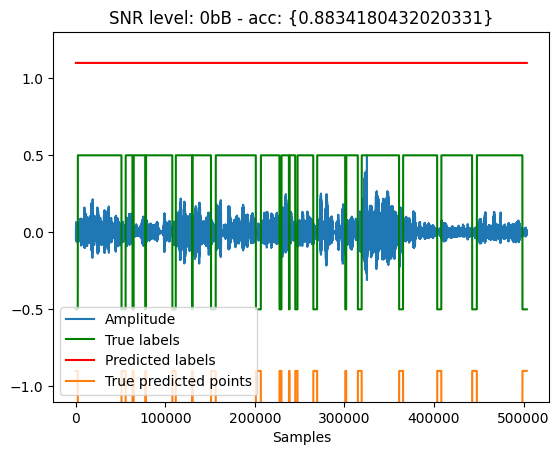

Time to execute model: 3.175973892211914


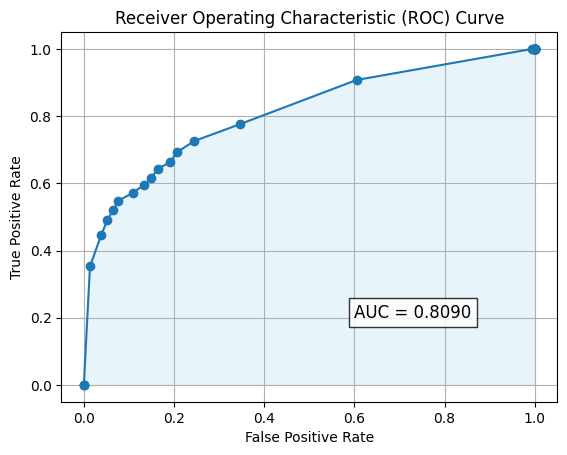

Accuracy : 0.8314049586776859
Make plot


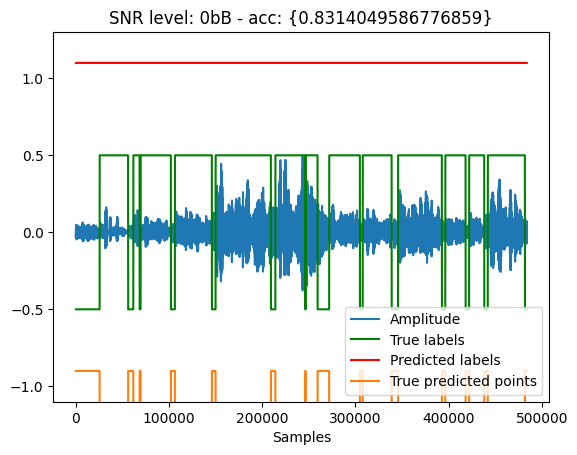

Time to execute model: 2.4862289428710938


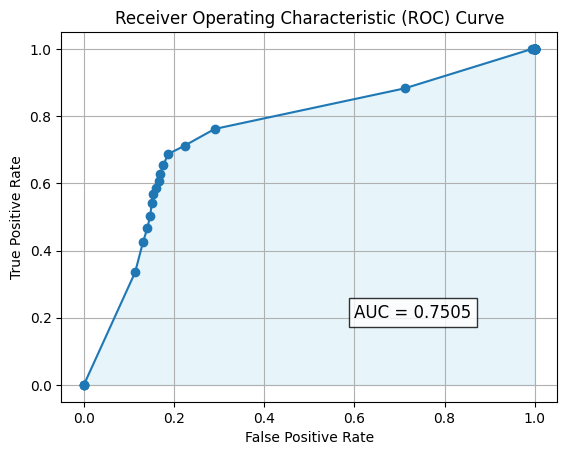

Accuracy : 0.8313384113166485
Make plot


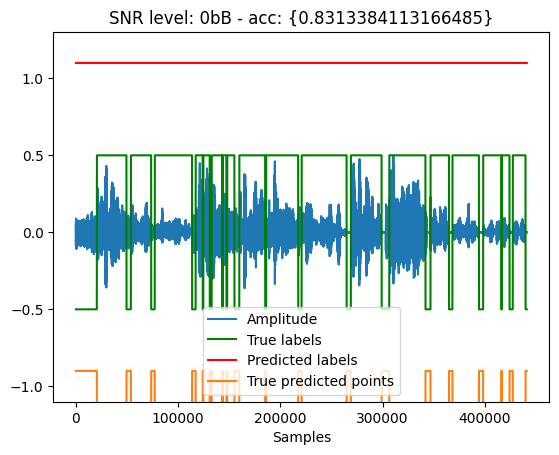

Time to execute model: 13.128280639648438


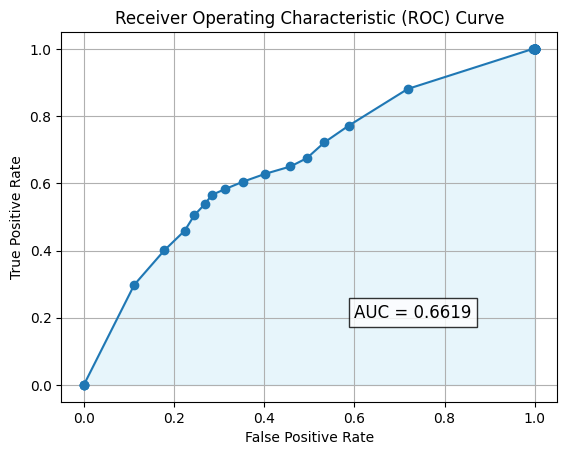

Epoch 2
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.393216
Loss DN: 4.712541341781616
Loss L: 0.01825060322880745
Accuracy of batch: 83.829881
Learning rate: 0.007000
Learning rate DN: 0.000007

Current file/Number of files: [   60/ 4620]
loss VAD: 0.404119
Loss DN: 4.709437727928162
Loss L: 0.0176742821931839
Accuracy of batch: 80.860832
Learning rate: 0.007000
Learning rate DN: 0.000007

Current file/Number of files: [   90/ 4620]
loss VAD: 0.431369
Loss DN: 4.753136873245239
Loss L: 0.017435796558856964
Accuracy of batch: 81.322111
Learning rate: 0.007000
Learning rate DN: 0.000007

Current file/Number of files: [  120/ 4620]
loss VAD: 0.382316
Loss DN: 4.726774454116821
Loss L: 0.017096159979701042
Accuracy of batch: 80.910499
Learning rate: 0.007000
Learning rate DN: 0.000007

Current file/Number of files: [  150/ 4620]
loss VAD: 0.356036
Loss DN: 4.752718806266785
Loss L: 0.01722230575978756
Accuracy of batch: 85.004748
Learning ra

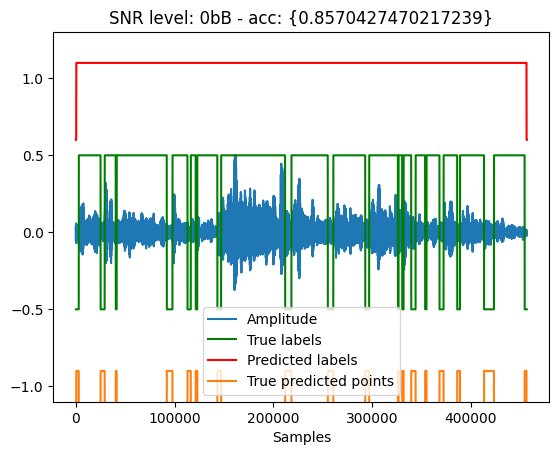

Time to execute model: 7.643461227416992


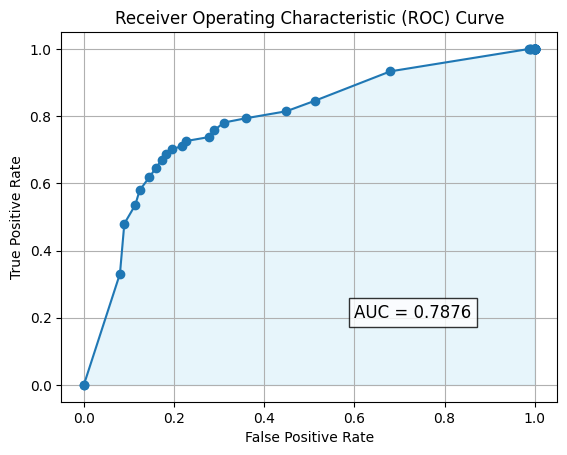

Accuracy : 0.8148765843895931
Make plot


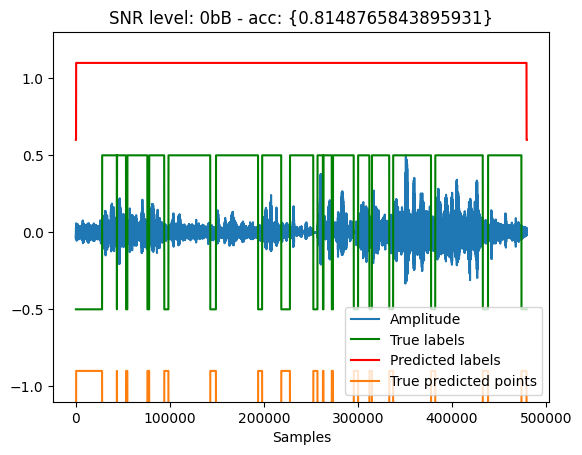

Time to execute model: 3.111600875854492


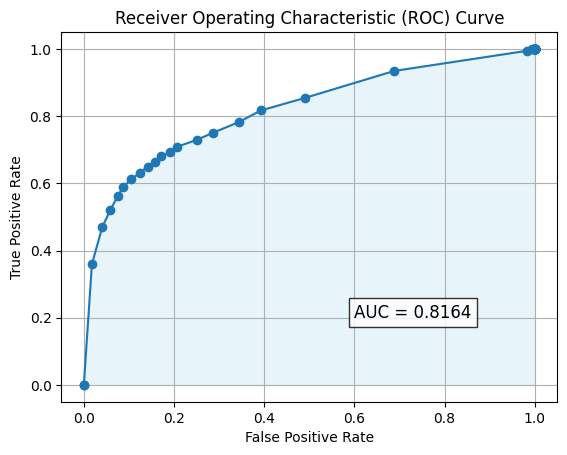

Accuracy : 0.8348845225784213
Make plot


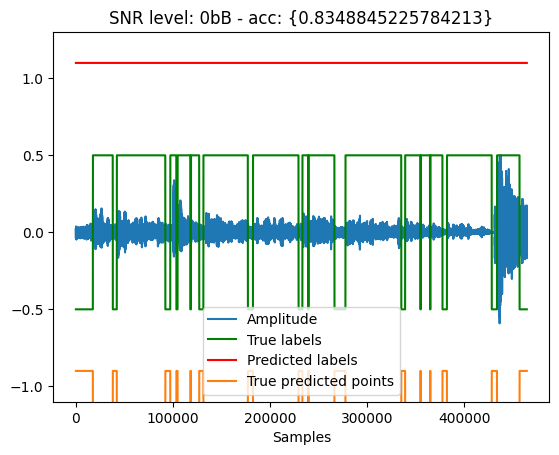

Time to execute model: 2.412080764770508


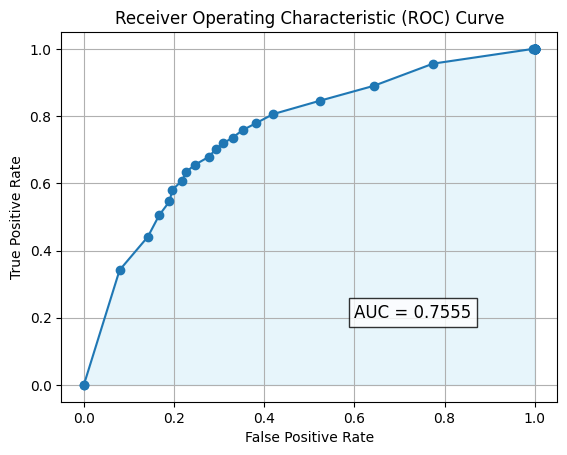

Epoch 3
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.354318
Loss DN: 4.7463743686676025
Loss L: 0.02779688686132431
Accuracy of batch: 82.266336
Learning rate: 0.004900
Learning rate DN: 0.000005

Current file/Number of files: [   60/ 4620]
loss VAD: 0.355220
Loss DN: 4.680049538612366
Loss L: 0.02750663459300995
Accuracy of batch: 83.463826
Learning rate: 0.004900
Learning rate DN: 0.000005

Current file/Number of files: [   90/ 4620]
loss VAD: 0.355749
Loss DN: 4.747912049293518
Loss L: 0.027388226240873337
Accuracy of batch: 82.037715
Learning rate: 0.004900
Learning rate DN: 0.000005

Current file/Number of files: [  120/ 4620]
loss VAD: 0.354441
Loss DN: 4.715391516685486
Loss L: 0.02713237889111042
Accuracy of batch: 80.672605
Learning rate: 0.004900
Learning rate DN: 0.000005

Current file/Number of files: [  150/ 4620]
loss VAD: 0.341271
Loss DN: 4.652406454086304
Loss L: 0.026828331872820854
Accuracy of batch: 82.772175
Learning 

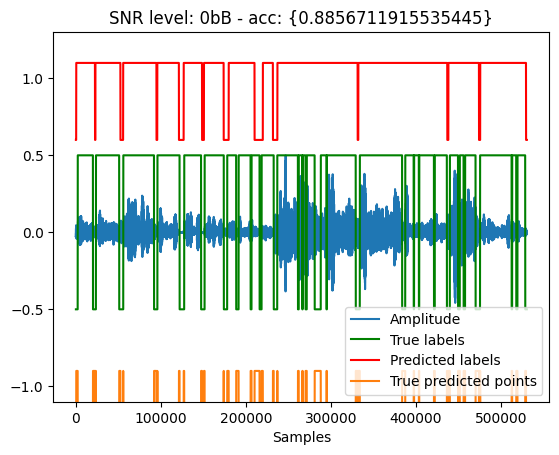

Time to execute model: 2.318143844604492


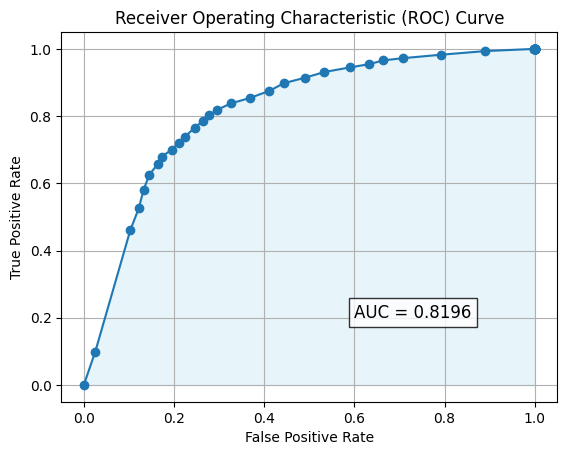

Accuracy : 0.8863920099875156
Make plot


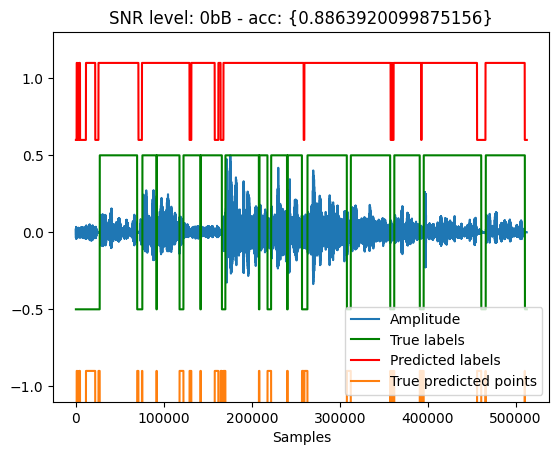

Time to execute model: 2.4688243865966797


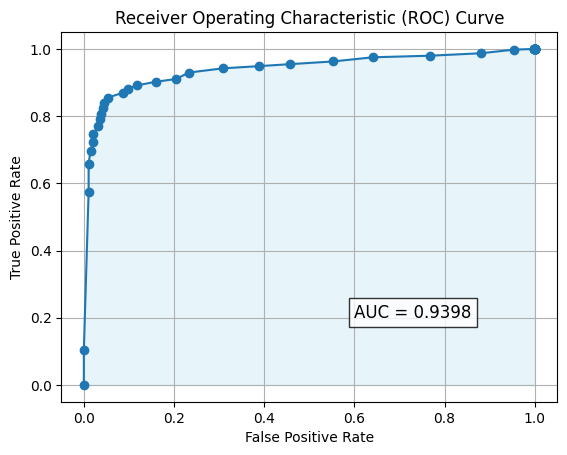

Accuracy : 0.8960848884010245
Make plot


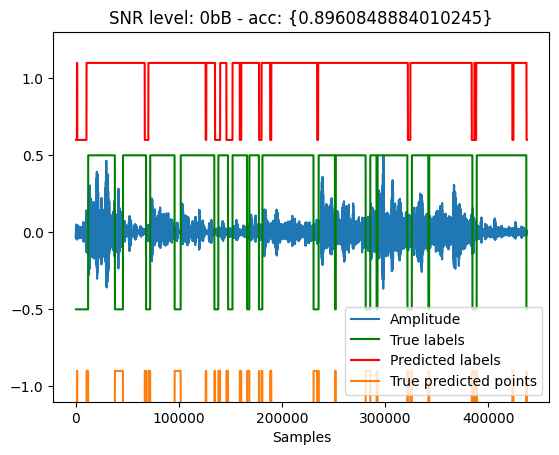

Time to execute model: 8.019685745239258


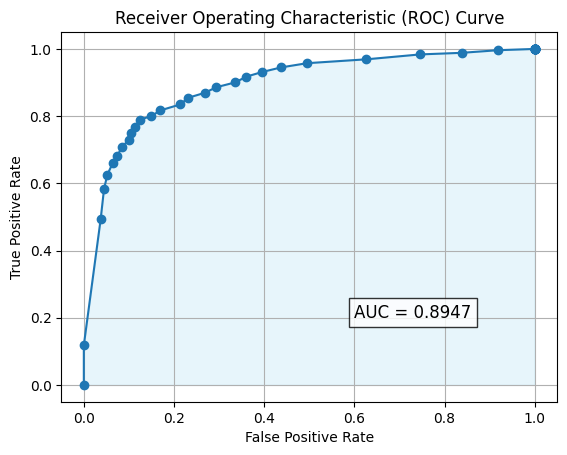

Epoch 4
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.259076
Loss DN: 4.748164057731628
Loss L: 0.022835448384284973
Accuracy of batch: 89.886462
Learning rate: 0.003430
Learning rate DN: 0.000003

Current file/Number of files: [   60/ 4620]
loss VAD: 0.274049
Loss DN: 4.655819892883301
Loss L: 0.02270965650677681
Accuracy of batch: 88.048762
Learning rate: 0.003430
Learning rate DN: 0.000003

Current file/Number of files: [   90/ 4620]
loss VAD: 0.281152
Loss DN: 4.68820059299469
Loss L: 0.022617537528276443
Accuracy of batch: 88.987094
Learning rate: 0.003430
Learning rate DN: 0.000003

Current file/Number of files: [  120/ 4620]
loss VAD: 0.318905
Loss DN: 4.682294011116028
Loss L: 0.02255222387611866
Accuracy of batch: 86.438069
Learning rate: 0.003430
Learning rate DN: 0.000003

Current file/Number of files: [  150/ 4620]
loss VAD: 0.286093
Loss DN: 4.711528182029724
Loss L: 0.02247249148786068
Accuracy of batch: 88.691248
Learning ra

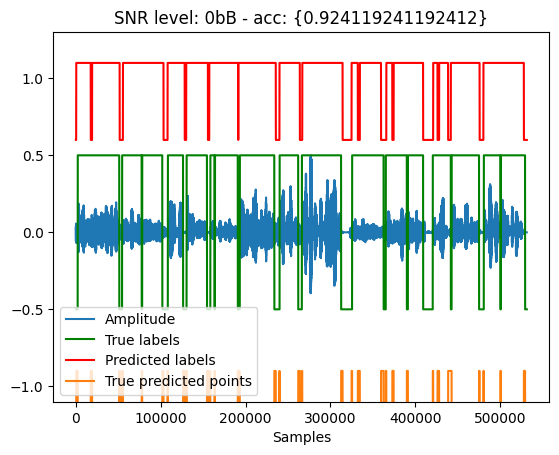

Time to execute model: 3.1714439392089844


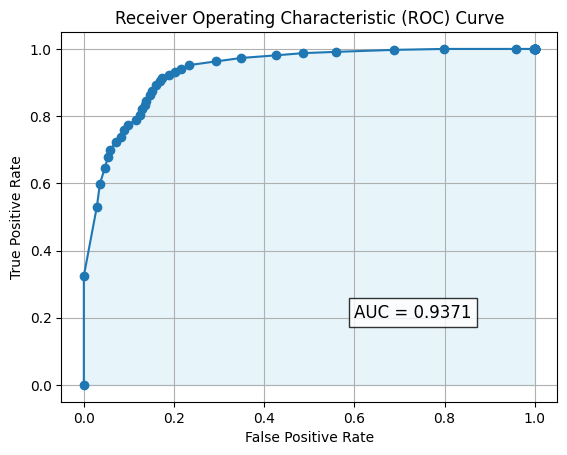

Accuracy : 0.9246367015883744
Make plot


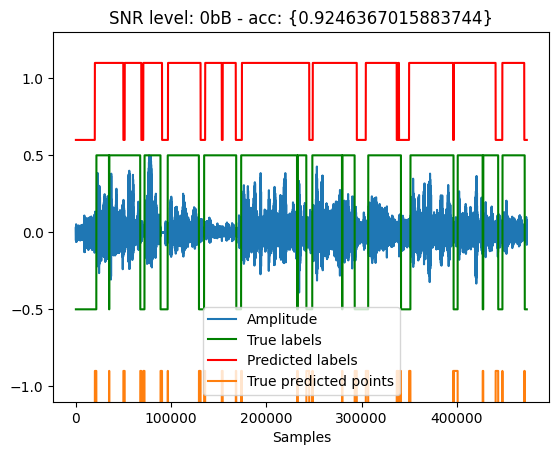

Time to execute model: 2.596139907836914


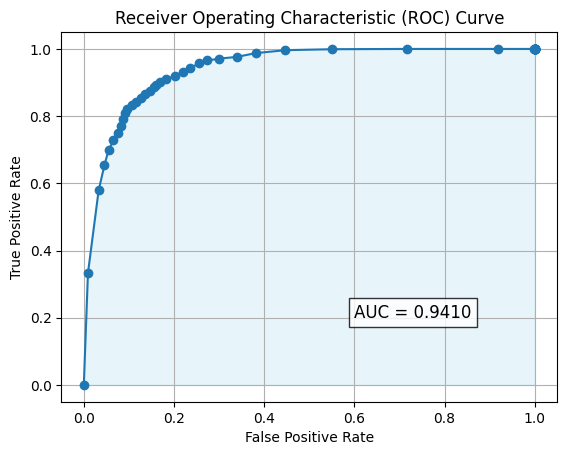

Accuracy : 0.8687767886580943
Make plot


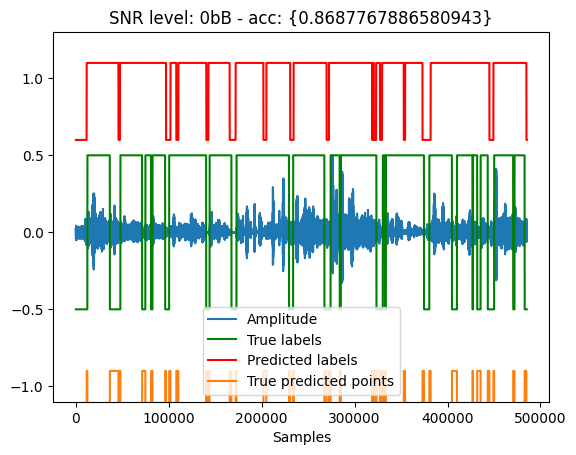

Time to execute model: 4.040002822875977


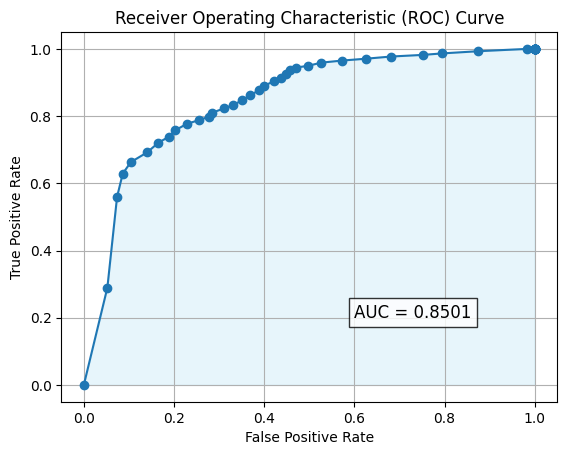

Epoch 5
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.261079
Loss DN: 4.67168402671814
Loss L: 0.021926695480942726
Accuracy of batch: 91.128452
Learning rate: 0.002401
Learning rate DN: 0.000002

Current file/Number of files: [   60/ 4620]
loss VAD: 0.262583
Loss DN: 4.689682245254517
Loss L: 0.021897926926612854
Accuracy of batch: 90.751435
Learning rate: 0.002401
Learning rate DN: 0.000002

Current file/Number of files: [   90/ 4620]
loss VAD: 0.247868
Loss DN: 4.788227796554565
Loss L: 0.02186187356710434
Accuracy of batch: 91.625234
Learning rate: 0.002401
Learning rate DN: 0.000002

Current file/Number of files: [  120/ 4620]
loss VAD: 0.262217
Loss DN: 4.7287691831588745
Loss L: 0.021850934252142906
Accuracy of batch: 89.324910
Learning rate: 0.002401
Learning rate DN: 0.000002

Current file/Number of files: [  150/ 4620]
loss VAD: 0.279664
Loss DN: 4.6948676109313965
Loss L: 0.021828070282936096
Accuracy of batch: 88.207001
Learnin

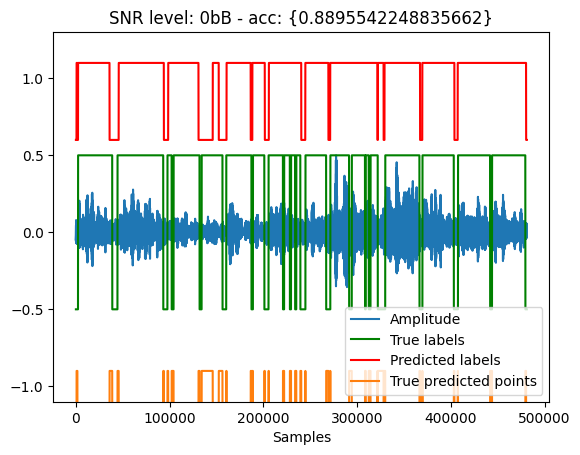

Time to execute model: 2.6946067810058594


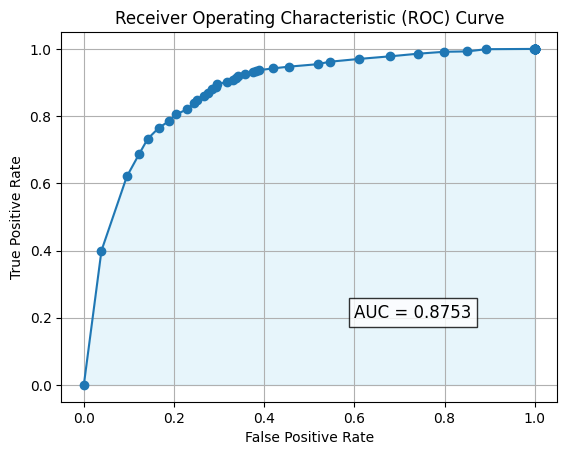

Accuracy : 0.8947730398899587
Make plot


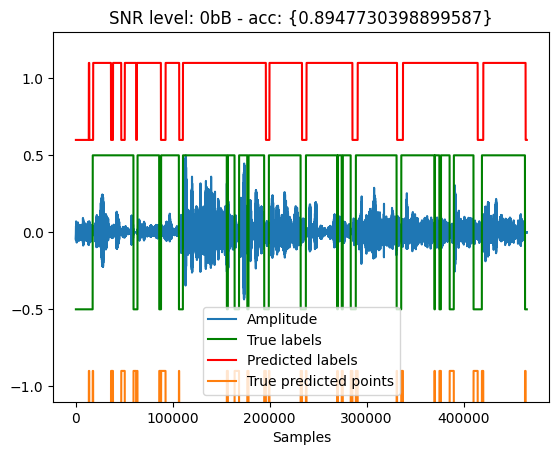

Time to execute model: 2.6302337646484375


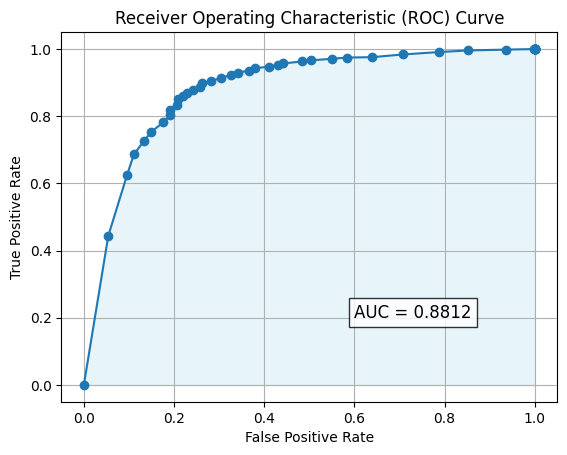

Accuracy : 0.9263292761050609
Make plot


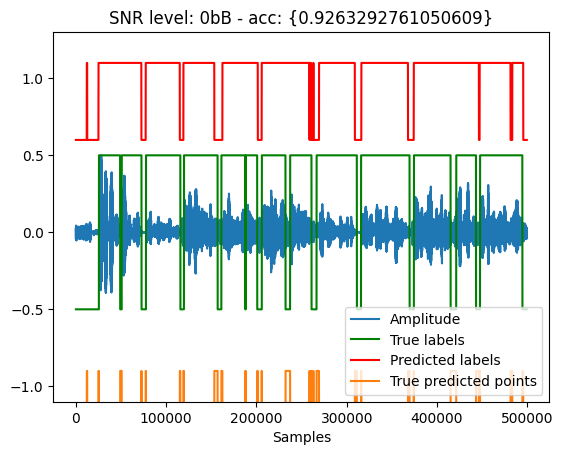

Time to execute model: 2.8524398803710938


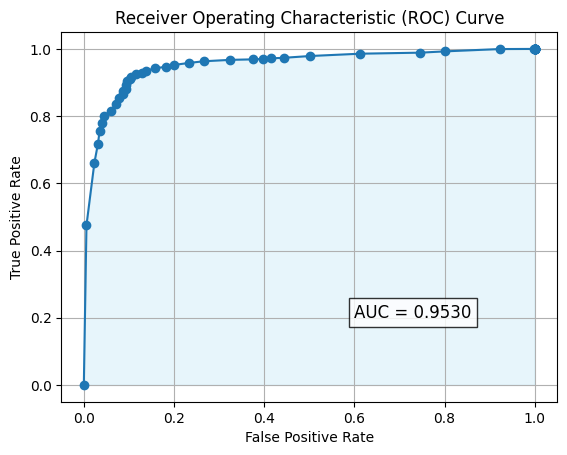

Epoch 6
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.225935
Loss DN: 4.685059309005737
Loss L: 0.021820668131113052
Accuracy of batch: 92.379848
Learning rate: 0.001681
Learning rate DN: 0.000002

Current file/Number of files: [   60/ 4620]
loss VAD: 0.224776
Loss DN: 4.608988046646118
Loss L: 0.021800963208079338
Accuracy of batch: 91.832190
Learning rate: 0.001681
Learning rate DN: 0.000002

Current file/Number of files: [   90/ 4620]
loss VAD: 0.240480
Loss DN: 4.749362230300903
Loss L: 0.021824363619089127
Accuracy of batch: 92.181973
Learning rate: 0.001681
Learning rate DN: 0.000002

Current file/Number of files: [  120/ 4620]
loss VAD: 0.224251
Loss DN: 4.758653283119202
Loss L: 0.021820969879627228
Accuracy of batch: 92.663804
Learning rate: 0.001681
Learning rate DN: 0.000002

Current file/Number of files: [  150/ 4620]
loss VAD: 0.256285
Loss DN: 4.624730348587036
Loss L: 0.021824149414896965
Accuracy of batch: 89.594506
Learnin

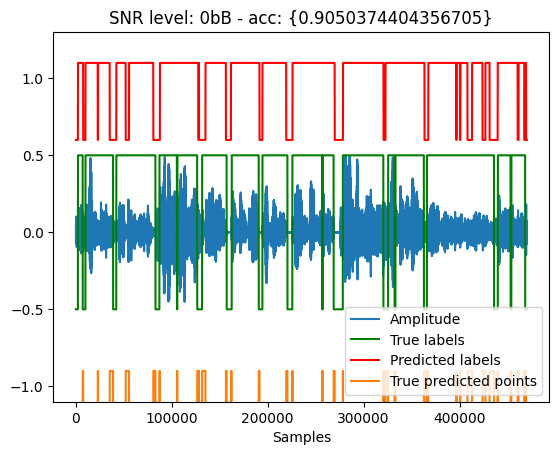

Time to execute model: 2.1071434020996094


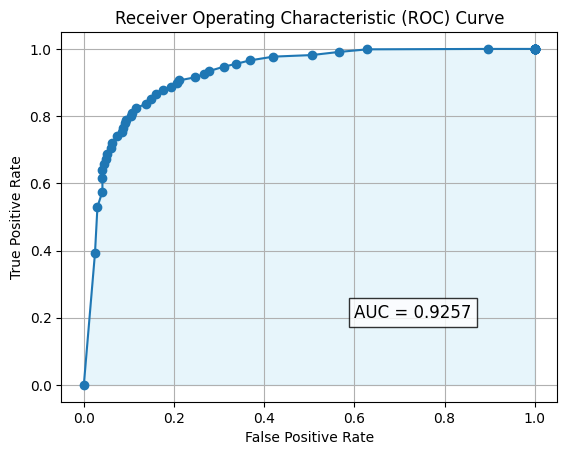

Accuracy : 0.897370653095844
Make plot


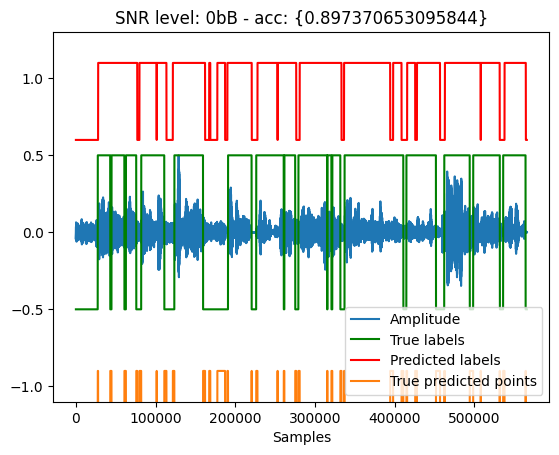

Time to execute model: 2.6319026947021484


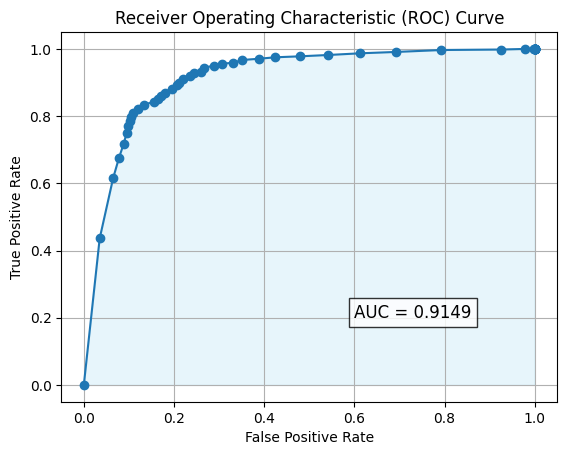

Accuracy : 0.9305724725943971
Make plot


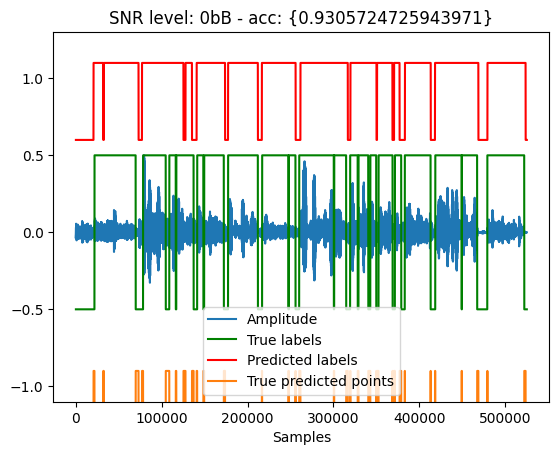

Time to execute model: 2.7937889099121094


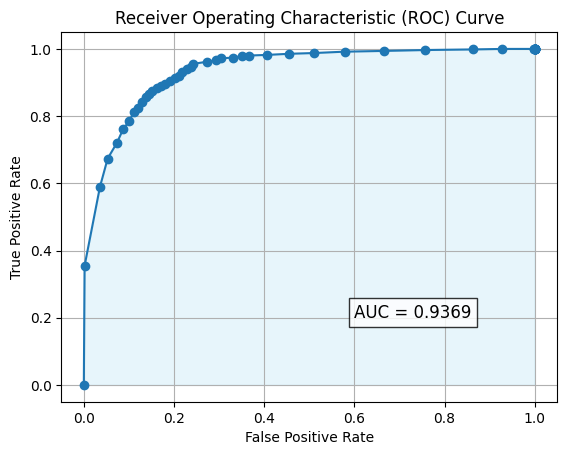

Epoch 7
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.233553
Loss DN: 4.648776292800903
Loss L: 0.0214607622474432
Accuracy of batch: 92.137020
Learning rate: 0.001176
Learning rate DN: 0.000001

Current file/Number of files: [   60/ 4620]
loss VAD: 0.239054
Loss DN: 4.600682854652405
Loss L: 0.021460343152284622
Accuracy of batch: 91.671404
Learning rate: 0.001176
Learning rate DN: 0.000001

Current file/Number of files: [   90/ 4620]
loss VAD: 0.262955
Loss DN: 4.584396600723267
Loss L: 0.021461961790919304
Accuracy of batch: 91.345773
Learning rate: 0.001176
Learning rate DN: 0.000001

Current file/Number of files: [  120/ 4620]
loss VAD: 0.266717
Loss DN: 4.723107218742371
Loss L: 0.02146049588918686
Accuracy of batch: 90.460920
Learning rate: 0.001176
Learning rate DN: 0.000001

Current file/Number of files: [  150/ 4620]
loss VAD: 0.234991
Loss DN: 4.699628114700317
Loss L: 0.02146182581782341
Accuracy of batch: 91.771285
Learning ra

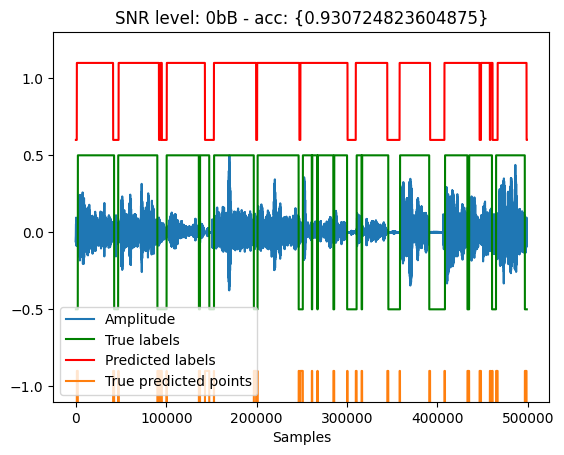

Time to execute model: 2.505064010620117


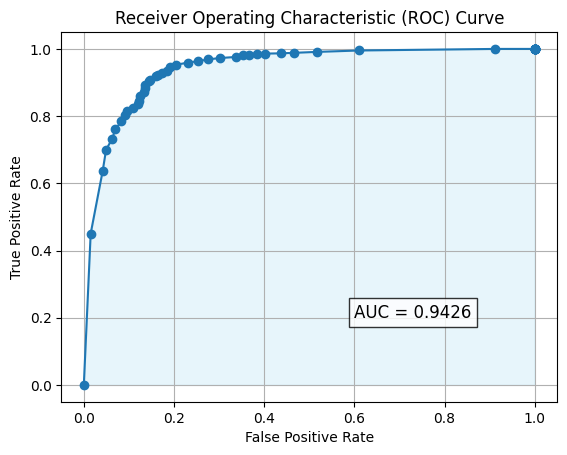

Accuracy : 0.9314712569015914
Make plot


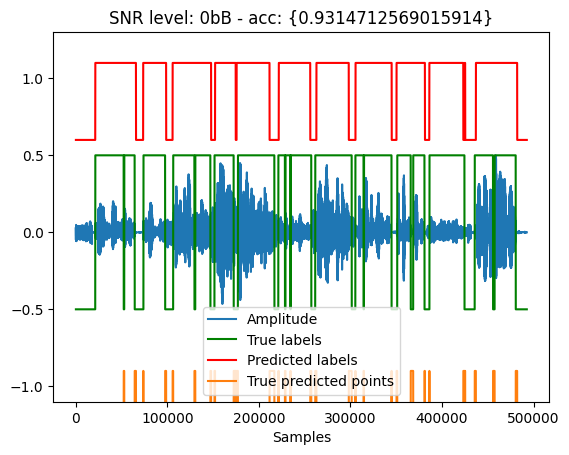

Time to execute model: 2.547740936279297


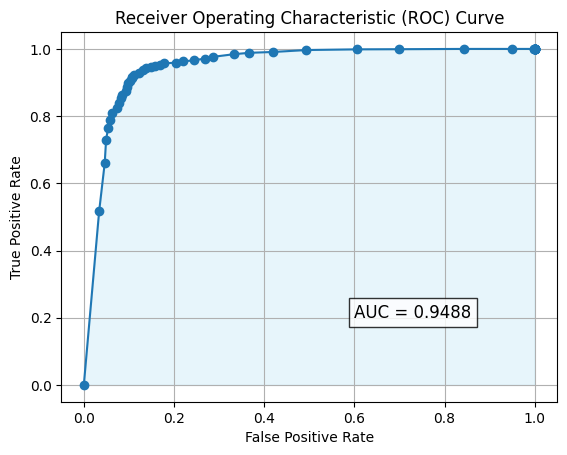

Accuracy : 0.9162303664921466
Make plot


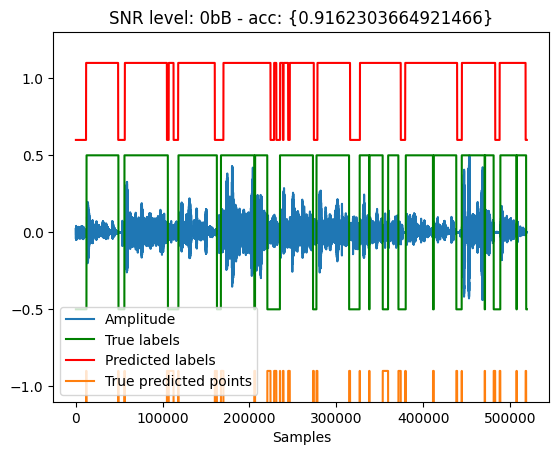

Time to execute model: 2.4733543395996094


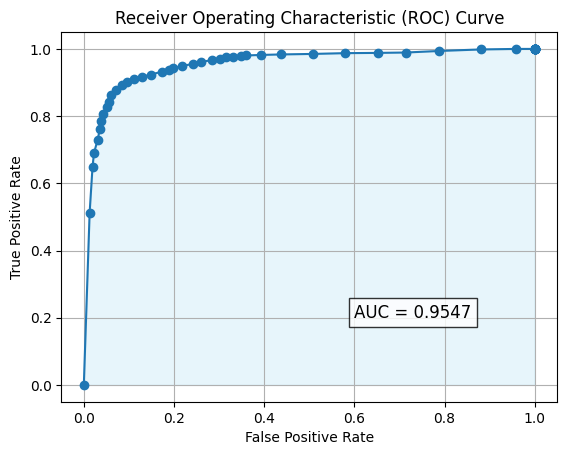

Epoch 8
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.219764
Loss DN: 4.701374769210815
Loss L: 0.02154514007270336
Accuracy of batch: 92.618405
Learning rate: 0.000824
Learning rate DN: 0.000001

Current file/Number of files: [   60/ 4620]
loss VAD: 0.229758
Loss DN: 4.858453750610352
Loss L: 0.021541133522987366
Accuracy of batch: 92.073785
Learning rate: 0.000824
Learning rate DN: 0.000001

Current file/Number of files: [   90/ 4620]
loss VAD: 0.218399
Loss DN: 4.678714394569397
Loss L: 0.021533560007810593
Accuracy of batch: 92.287658
Learning rate: 0.000824
Learning rate DN: 0.000001

Current file/Number of files: [  120/ 4620]
loss VAD: 0.198597
Loss DN: 4.7676743268966675
Loss L: 0.021531881764531136
Accuracy of batch: 93.259677
Learning rate: 0.000824
Learning rate DN: 0.000001

Current file/Number of files: [  150/ 4620]
loss VAD: 0.226668
Loss DN: 4.656826615333557
Loss L: 0.021532785147428513
Accuracy of batch: 92.406445
Learnin

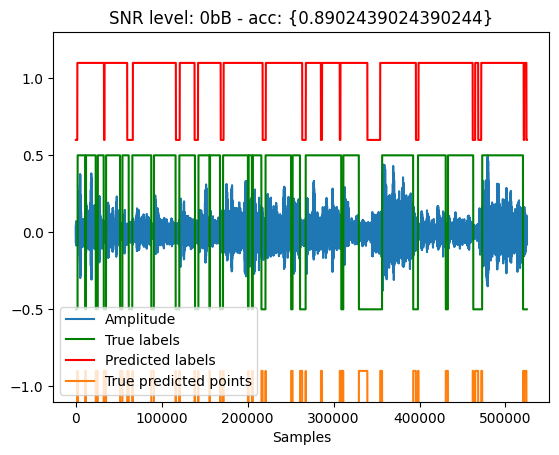

Time to execute model: 2.7265548706054688


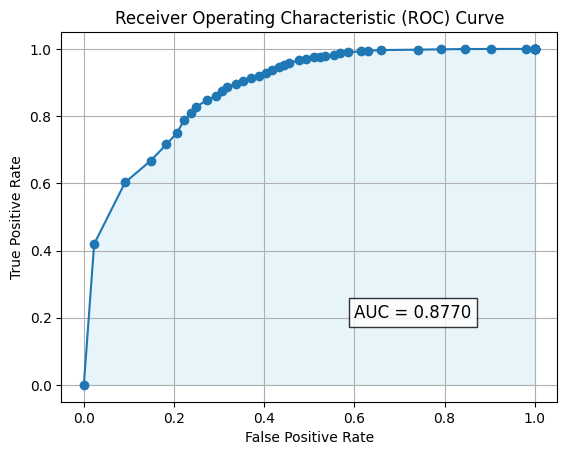

Accuracy : 0.9327964454318245
Make plot


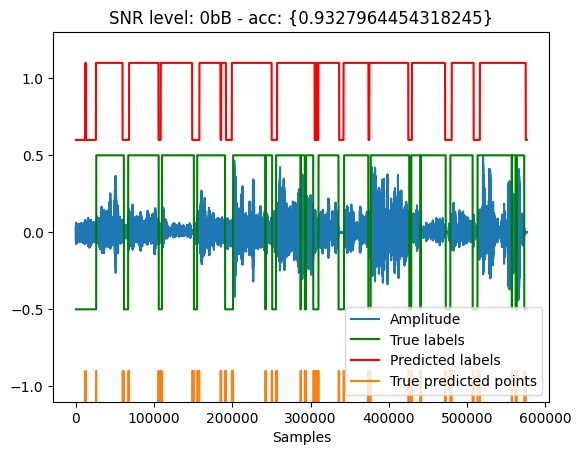

Time to execute model: 2.398252487182617


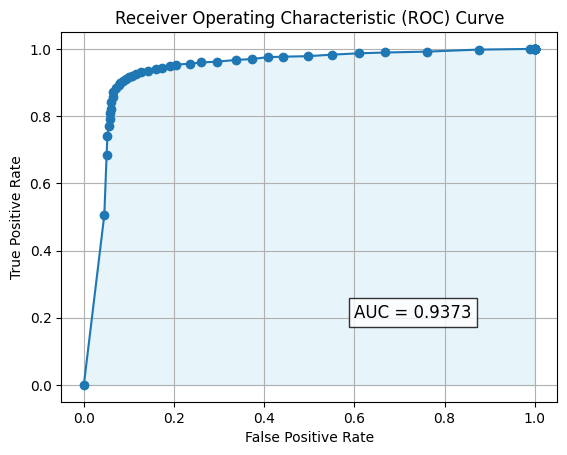

Accuracy : 0.9084084084084084
Make plot


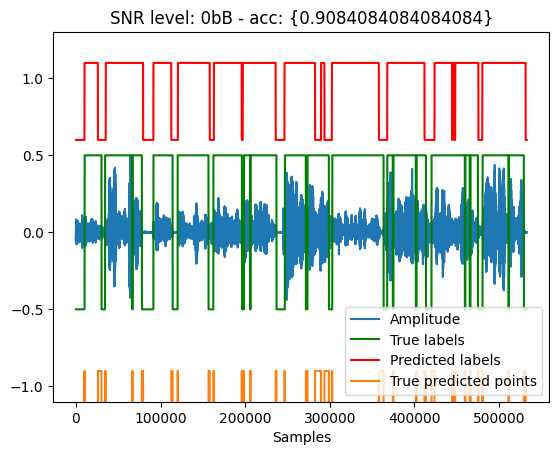

Time to execute model: 2.288341522216797


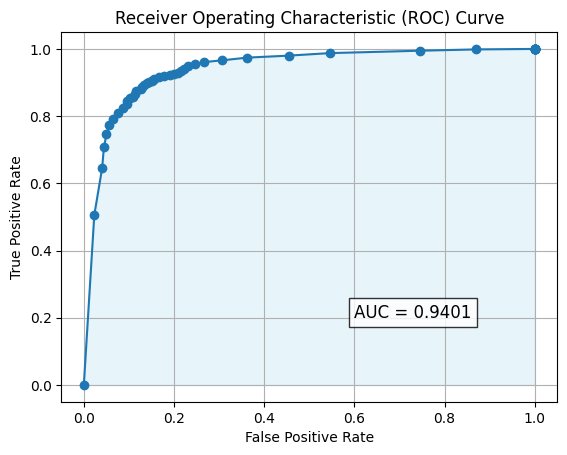

Epoch 9
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.224062
Loss DN: 4.713605642318726
Loss L: 0.021477388218045235
Accuracy of batch: 92.516673
Learning rate: 0.000576
Learning rate DN: 0.000001

Current file/Number of files: [   60/ 4620]
loss VAD: 0.231972
Loss DN: 4.707438945770264
Loss L: 0.021476106718182564
Accuracy of batch: 91.509644
Learning rate: 0.000576
Learning rate DN: 0.000001

Current file/Number of files: [   90/ 4620]
loss VAD: 0.214324
Loss DN: 4.520560264587402
Loss L: 0.021476000547409058
Accuracy of batch: 92.062865
Learning rate: 0.000576
Learning rate DN: 0.000001

Current file/Number of files: [  120/ 4620]
loss VAD: 0.240033
Loss DN: 4.780970573425293
Loss L: 0.021475357934832573
Accuracy of batch: 91.630813
Learning rate: 0.000576
Learning rate DN: 0.000001

Current file/Number of files: [  150/ 4620]
loss VAD: 0.208008
Loss DN: 4.703414082527161
Loss L: 0.021474752575159073
Accuracy of batch: 93.432944
Learnin

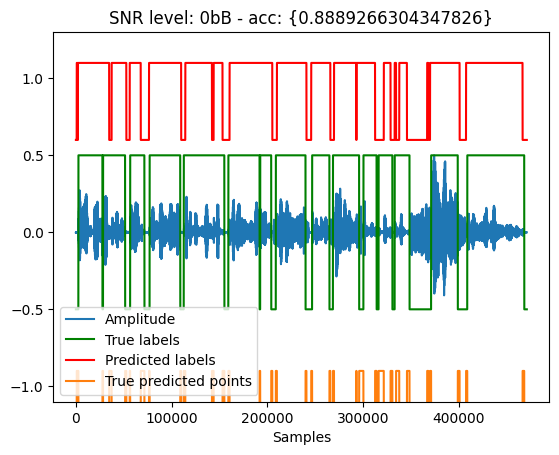

Time to execute model: 2.8383731842041016


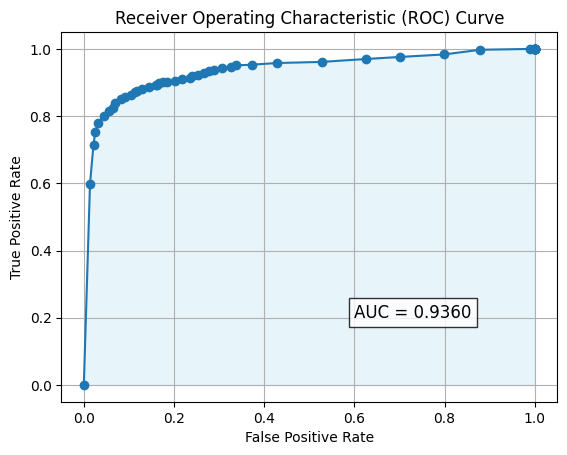

Accuracy : 0.9302325581395349
Make plot


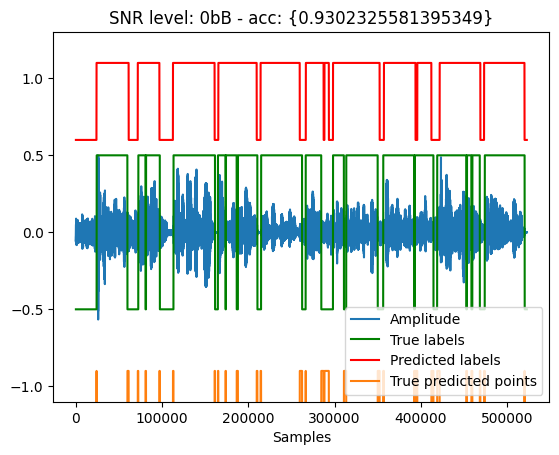

Time to execute model: 2.593517303466797


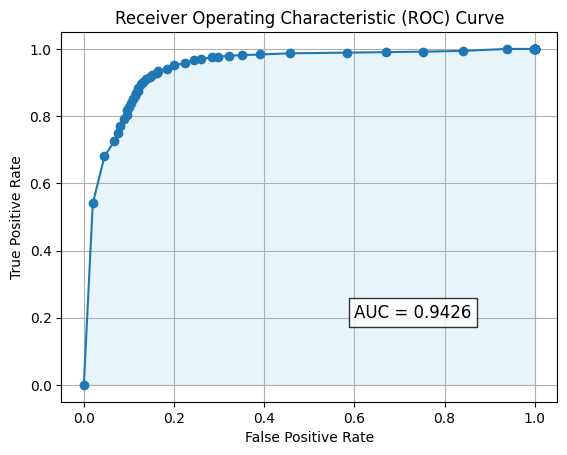

Accuracy : 0.9200857317819964
Make plot


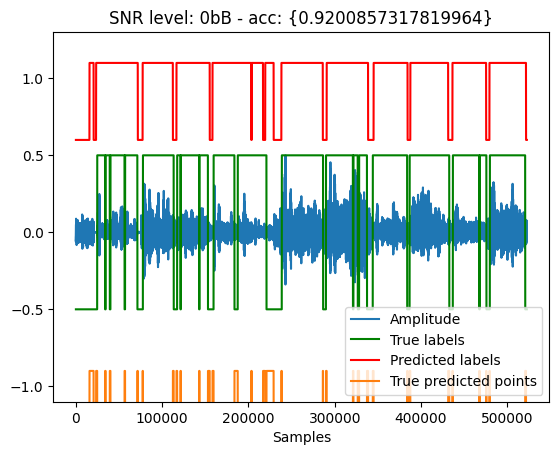

Time to execute model: 3.9250850677490234


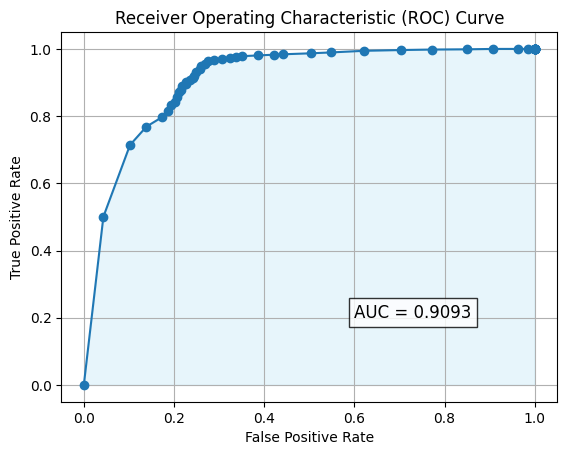

Epoch 10
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.228393
Loss DN: 4.717527389526367
Loss L: 0.021386630833148956
Accuracy of batch: 91.690499
Learning rate: 0.000404
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.216535
Loss DN: 4.745444059371948
Loss L: 0.021384628489613533
Accuracy of batch: 93.391030
Learning rate: 0.000404
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.211942
Loss DN: 4.696953177452087
Loss L: 0.021382596343755722
Accuracy of batch: 93.023996
Learning rate: 0.000404
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.199982
Loss DN: 4.7007075548172
Loss L: 0.021381279453635216
Accuracy of batch: 93.587570
Learning rate: 0.000404
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.222981
Loss DN: 4.724732398986816
Loss L: 0.0213832575827837
Accuracy of batch: 92.067392
Learning r

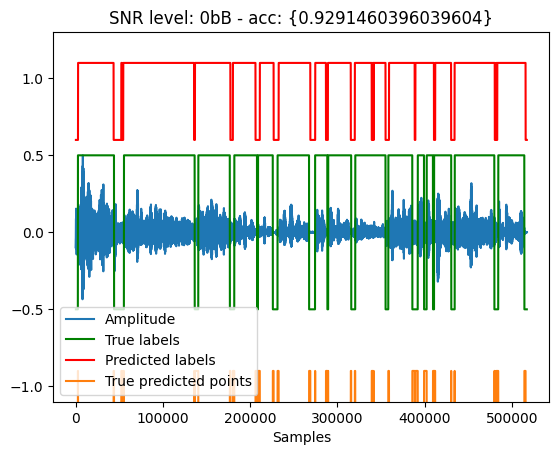

Time to execute model: 2.3651123046875


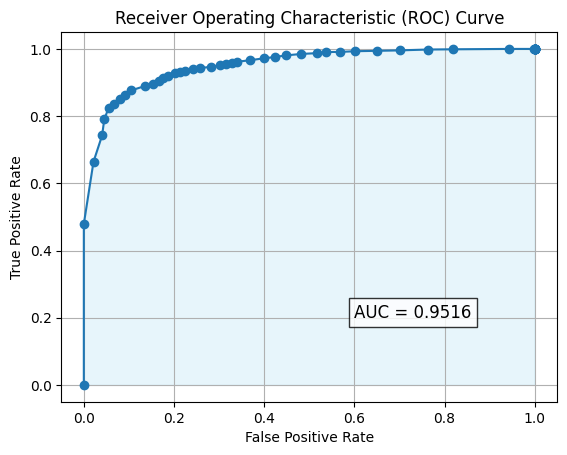

Accuracy : 0.9395723582274559
Make plot


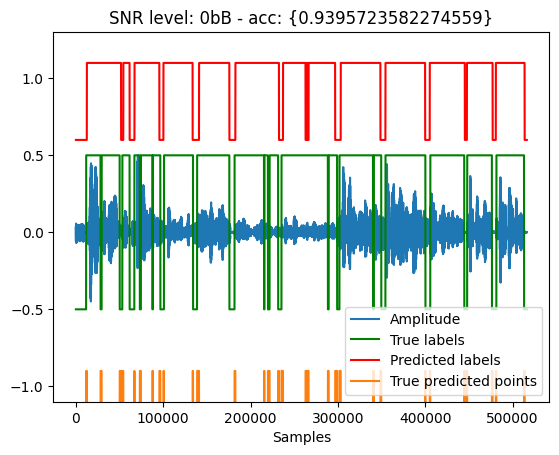

Time to execute model: 2.3565292358398438


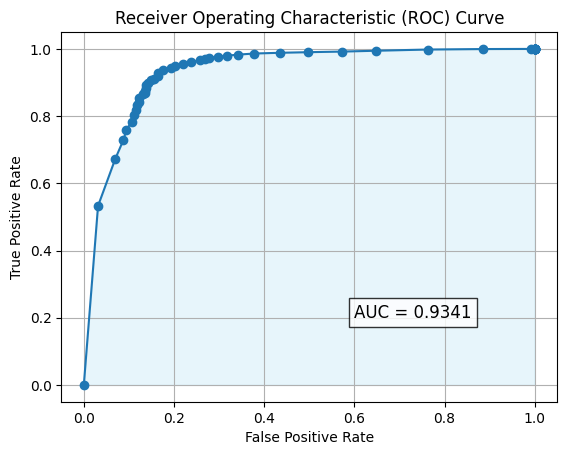

Accuracy : 0.9420118343195266
Make plot


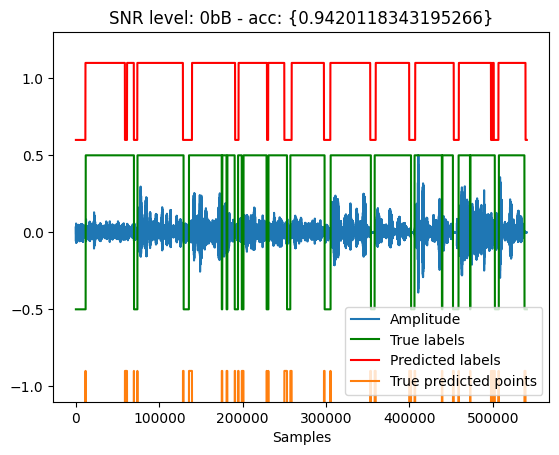

Time to execute model: 2.399444580078125


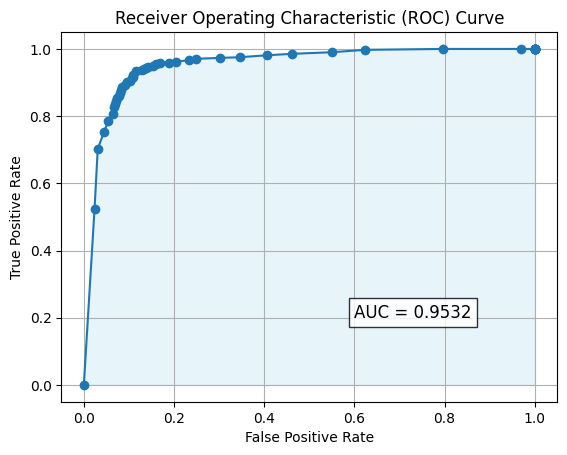

Epoch 11
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.196949
Loss DN: 4.72195827960968
Loss L: 0.02129802480340004
Accuracy of batch: 93.266090
Learning rate: 0.000282
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.210943
Loss DN: 4.707335114479065
Loss L: 0.021296508610248566
Accuracy of batch: 92.397785
Learning rate: 0.000282
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.241285
Loss DN: 4.694790840148926
Loss L: 0.021295854821801186
Accuracy of batch: 90.587675
Learning rate: 0.000282
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.221751
Loss DN: 4.6683573722839355
Loss L: 0.02129128761589527
Accuracy of batch: 91.733172
Learning rate: 0.000282
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.247167
Loss DN: 4.712684869766235
Loss L: 0.02129211463034153
Accuracy of batch: 91.502762
Learning 

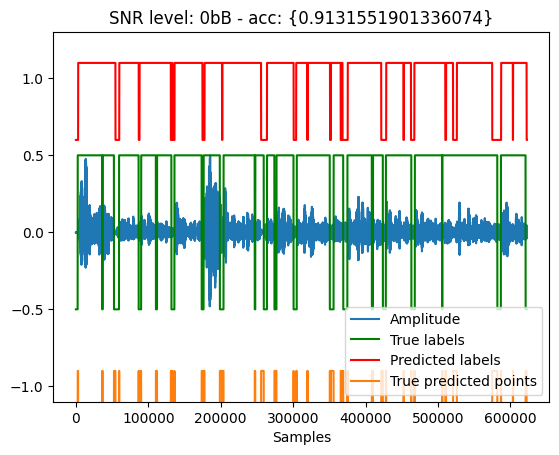

Time to execute model: 2.641916275024414


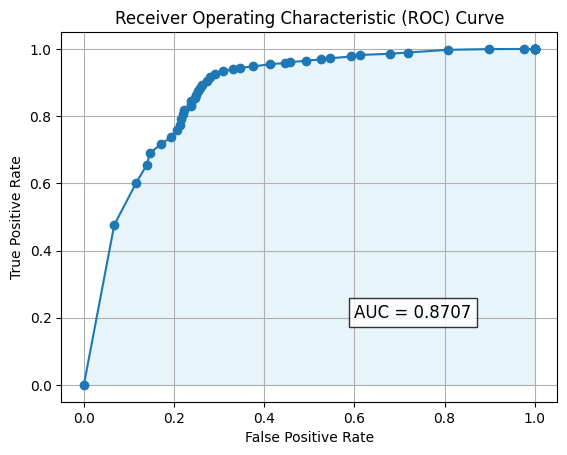

Accuracy : 0.9086969978334881
Make plot


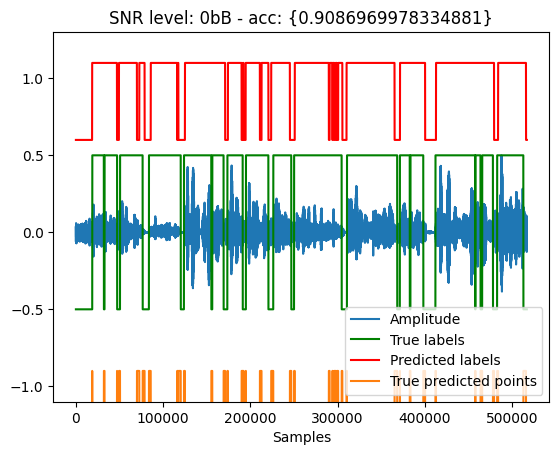

Time to execute model: 2.3908615112304688


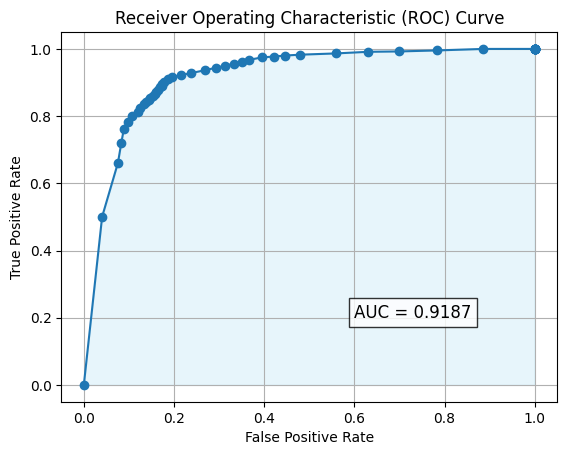

Accuracy : 0.9369019138755981
Make plot


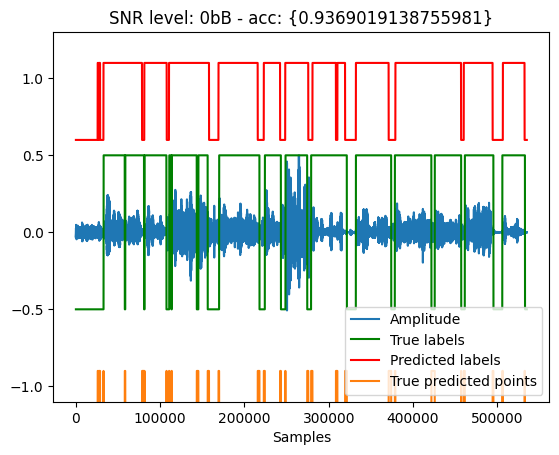

Time to execute model: 4.082679748535156


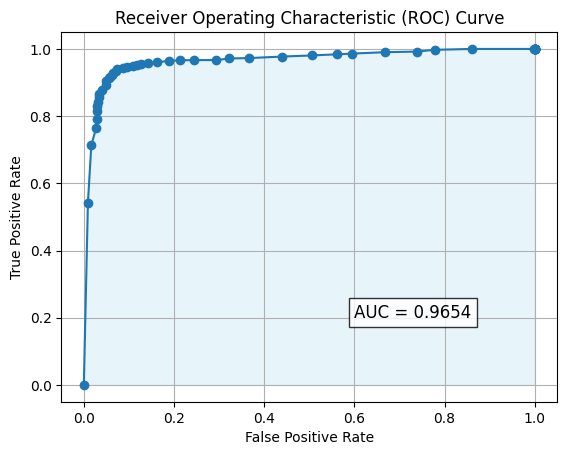

Epoch 12
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.209617
Loss DN: 4.849091172218323
Loss L: 0.021207185462117195
Accuracy of batch: 92.124393
Learning rate: 0.000198
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.237146
Loss DN: 4.759929895401001
Loss L: 0.021205073222517967
Accuracy of batch: 92.060994
Learning rate: 0.000198
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.228539
Loss DN: 4.6209070682525635
Loss L: 0.021203789860010147
Accuracy of batch: 91.918764
Learning rate: 0.000198
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.230035
Loss DN: 4.670375227928162
Loss L: 0.02120267041027546
Accuracy of batch: 91.614182
Learning rate: 0.000198
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.227394
Loss DN: 4.662243843078613
Loss L: 0.021204324439167976
Accuracy of batch: 92.600818
Learni

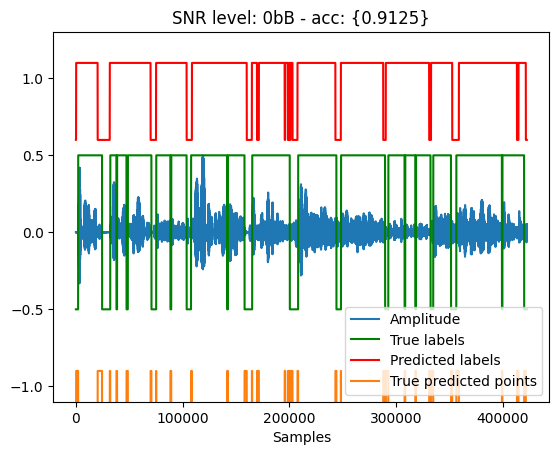

Time to execute model: 11.99650764465332


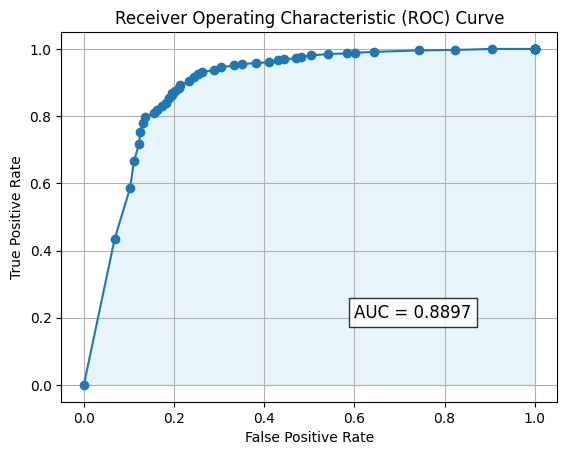

Accuracy : 0.9355185384202042
Make plot


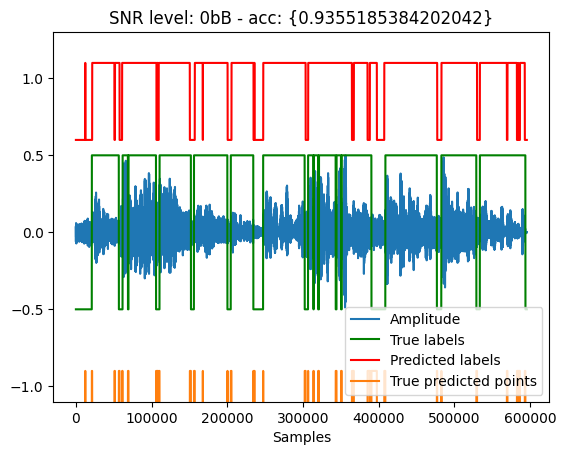

Time to execute model: 7.756948471069336


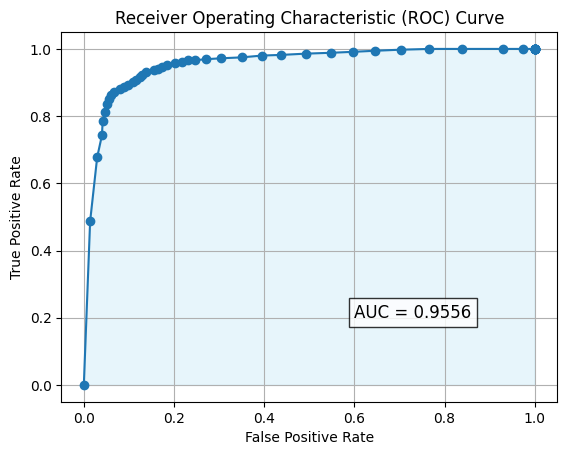

Accuracy : 0.9174694926140012
Make plot


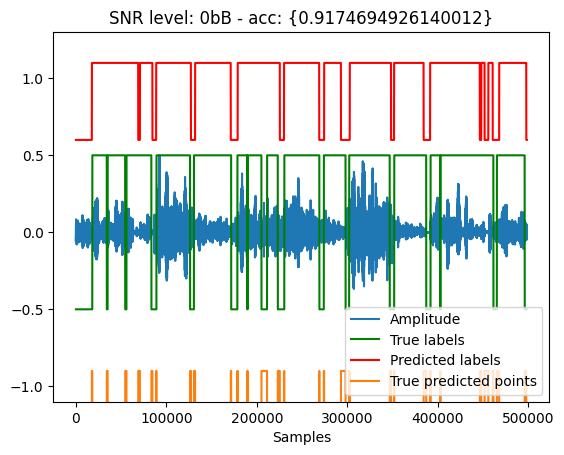

Time to execute model: 4.363298416137695


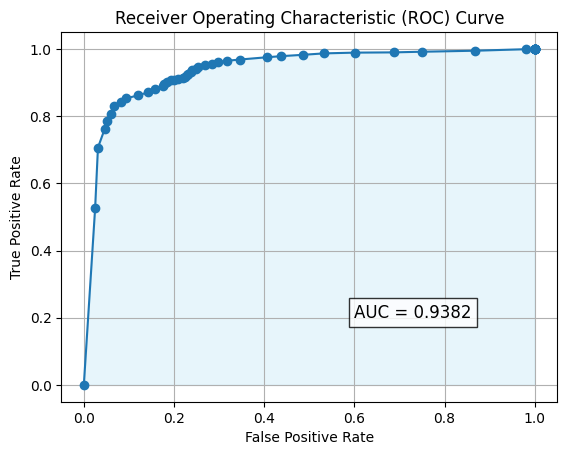

Epoch 13
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.206307
Loss DN: 4.654807925224304
Loss L: 0.021175039932131767
Accuracy of batch: 92.726638
Learning rate: 0.000138
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.210016
Loss DN: 4.718003511428833
Loss L: 0.021176153793931007
Accuracy of batch: 92.954968
Learning rate: 0.000138
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.206781
Loss DN: 4.6943336725234985
Loss L: 0.02117527835071087
Accuracy of batch: 92.710274
Learning rate: 0.000138
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.243788
Loss DN: 4.683558464050293
Loss L: 0.021176649257540703
Accuracy of batch: 92.194228
Learning rate: 0.000138
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.226316
Loss DN: 4.738728880882263
Loss L: 0.021175934001803398
Accuracy of batch: 92.200614
Learni

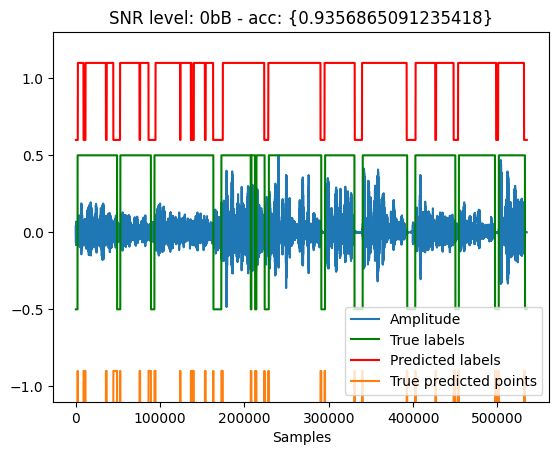

Time to execute model: 5.2738189697265625


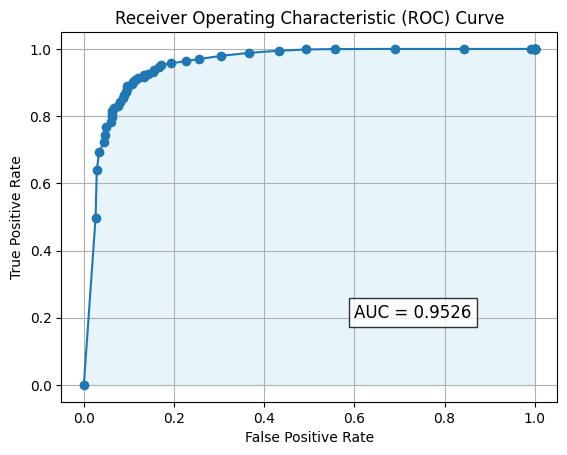

Accuracy : 0.9383370535714286
Make plot


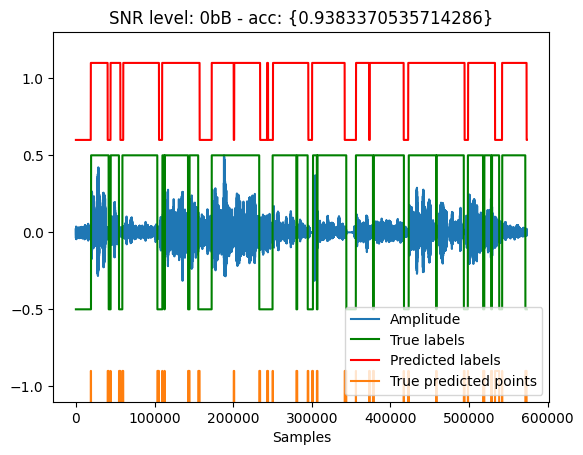

Time to execute model: 2.4263858795166016


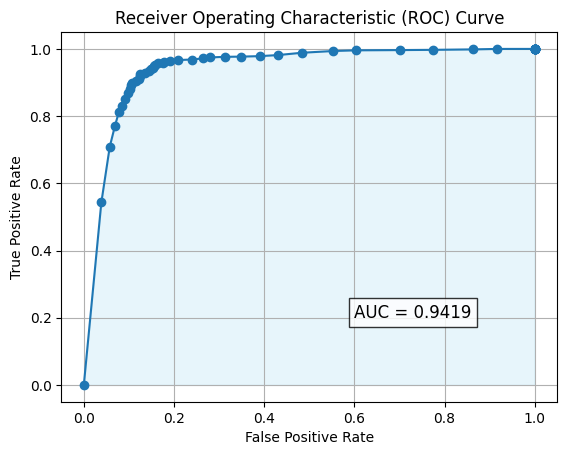

Accuracy : 0.8850377487989018
Make plot


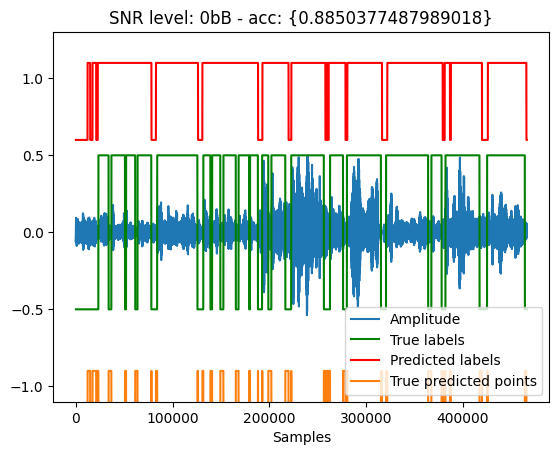

Time to execute model: 2.9571056365966797


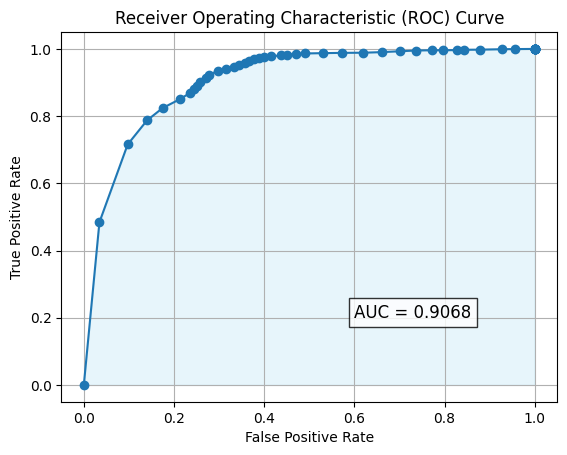

Epoch 14
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.219902
Loss DN: 4.640661954879761
Loss L: 0.02116820402443409
Accuracy of batch: 91.909547
Learning rate: 0.000097
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.197653
Loss DN: 4.671838045120239
Loss L: 0.02116783894598484
Accuracy of batch: 92.782243
Learning rate: 0.000097
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.217622
Loss DN: 4.66668426990509
Loss L: 0.02116711437702179
Accuracy of batch: 93.141459
Learning rate: 0.000097
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.195878
Loss DN: 4.664102554321289
Loss L: 0.021167006343603134
Accuracy of batch: 93.805298
Learning rate: 0.000097
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.212022
Loss DN: 4.75681459903717
Loss L: 0.021167416125535965
Accuracy of batch: 92.357687
Learning ra

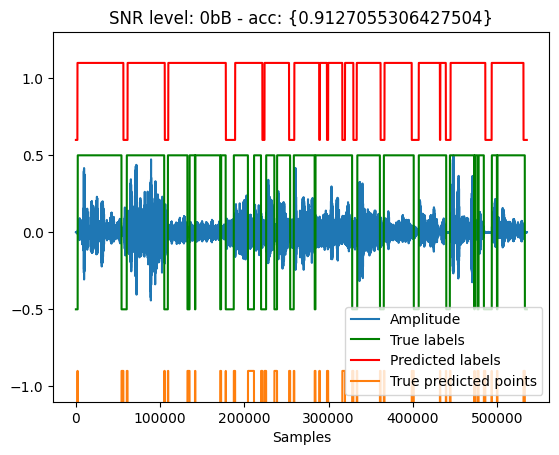

Time to execute model: 2.7282238006591797


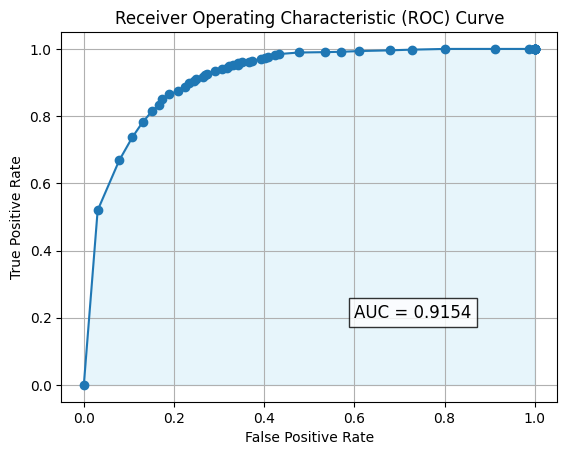

Accuracy : 0.9430780042164442
Make plot


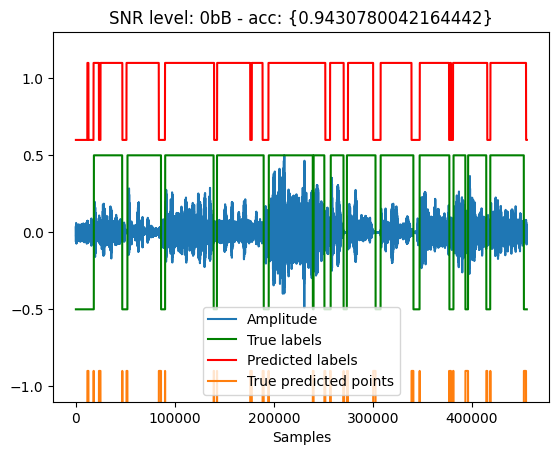

Time to execute model: 2.2592544555664062


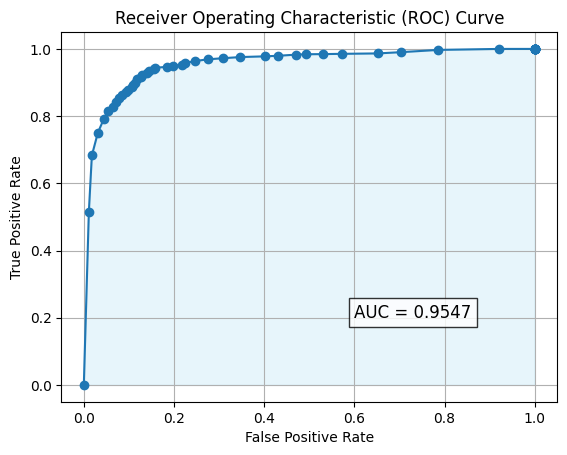

Accuracy : 0.9254747402364744
Make plot


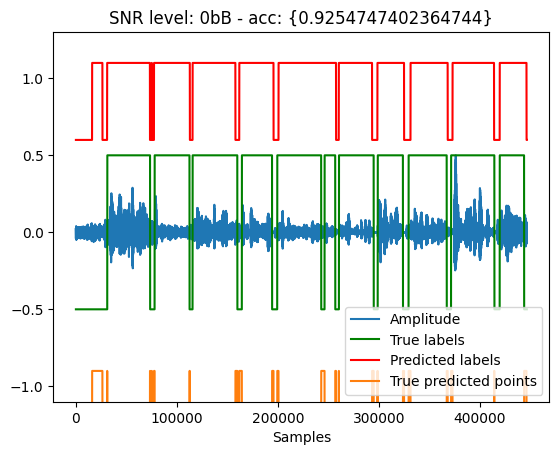

Time to execute model: 4.915714263916016


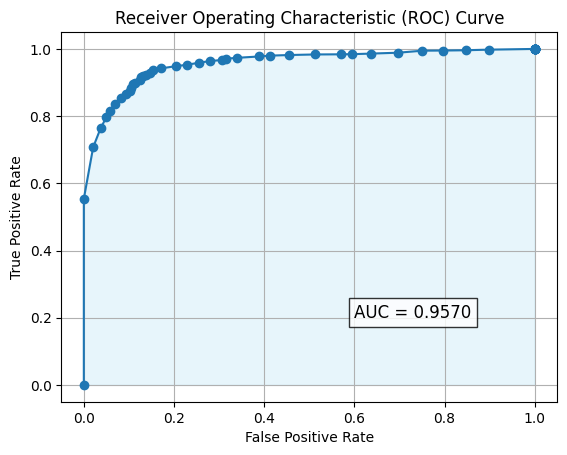

Epoch 15
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.214537
Loss DN: 4.6841384172439575
Loss L: 0.021171944215893745
Accuracy of batch: 93.276225
Learning rate: 0.000068
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.208247
Loss DN: 4.716020464897156
Loss L: 0.021171530708670616
Accuracy of batch: 92.453949
Learning rate: 0.000068
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.200793
Loss DN: 4.593227028846741
Loss L: 0.02117166295647621
Accuracy of batch: 92.957367
Learning rate: 0.000068
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.208658
Loss DN: 4.656575441360474
Loss L: 0.021171780303120613
Accuracy of batch: 93.138014
Learning rate: 0.000068
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.207521
Loss DN: 4.741149425506592
Loss L: 0.02117232047021389
Accuracy of batch: 93.588032
Learnin

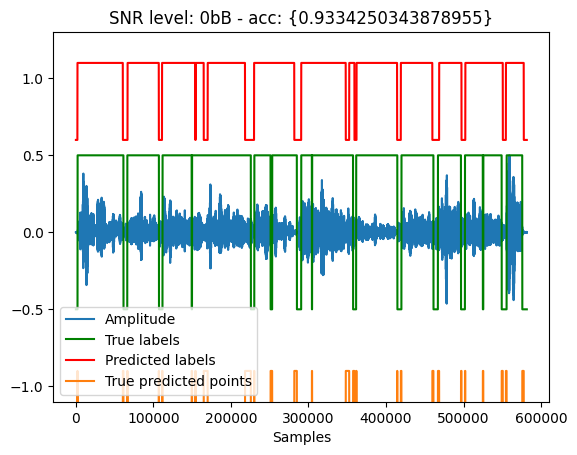

Time to execute model: 2.6450157165527344


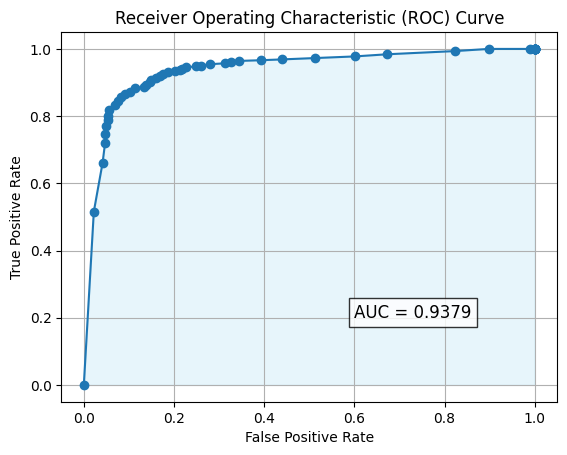

Accuracy : 0.9283276450511946
Make plot


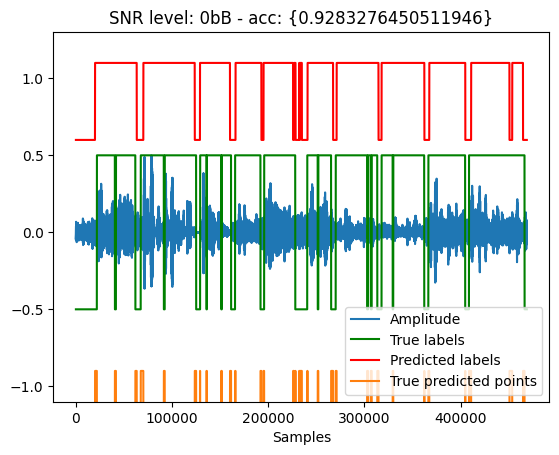

Time to execute model: 4.005908966064453


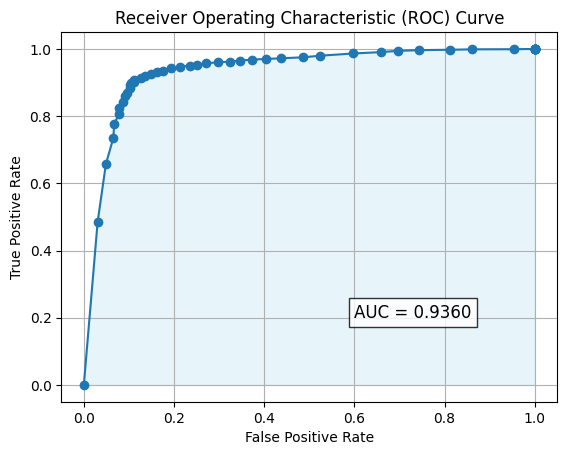

Accuracy : 0.9343679275784028
Make plot


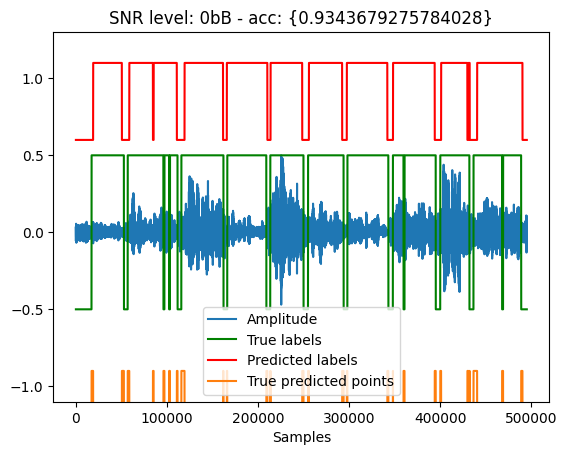

Time to execute model: 2.3491382598876953


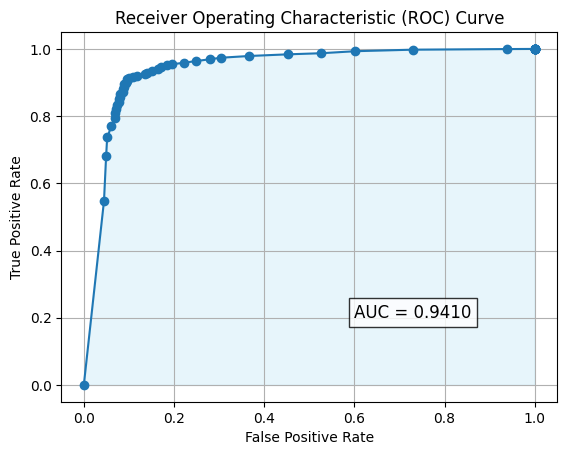

Epoch 16
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.217950
Loss DN: 4.72776997089386
Loss L: 0.02117234468460083
Accuracy of batch: 92.799337
Learning rate: 0.000047
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.204774
Loss DN: 4.723093390464783
Loss L: 0.021172450855374336
Accuracy of batch: 92.317238
Learning rate: 0.000047
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.210266
Loss DN: 4.629689812660217
Loss L: 0.0211725365370512
Accuracy of batch: 93.579963
Learning rate: 0.000047
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.233384
Loss DN: 4.785323858261108
Loss L: 0.021172726526856422
Accuracy of batch: 91.261435
Learning rate: 0.000047
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.216566
Loss DN: 4.626659035682678
Loss L: 0.021172387525439262
Accuracy of batch: 92.619818
Learning r

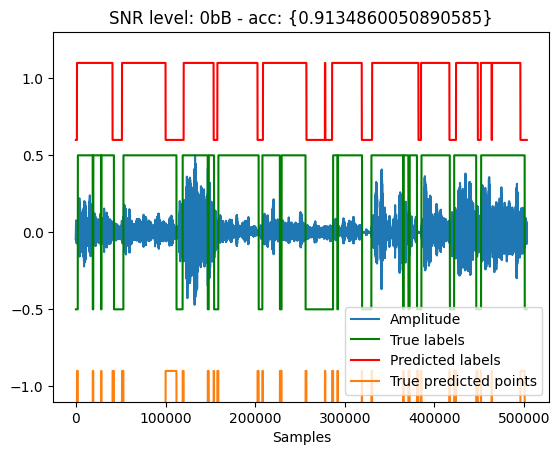

Time to execute model: 2.6750564575195312


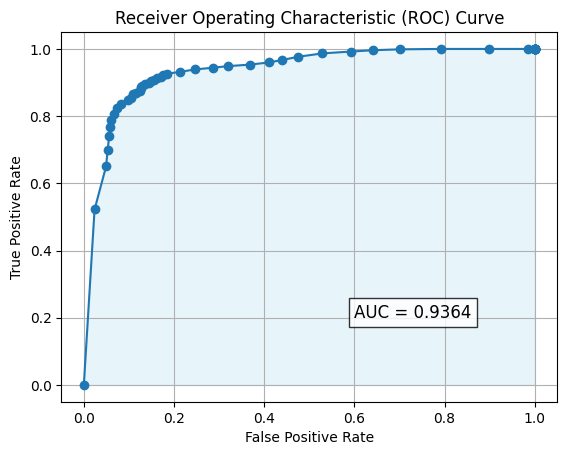

Accuracy : 0.9233961059687201
Make plot


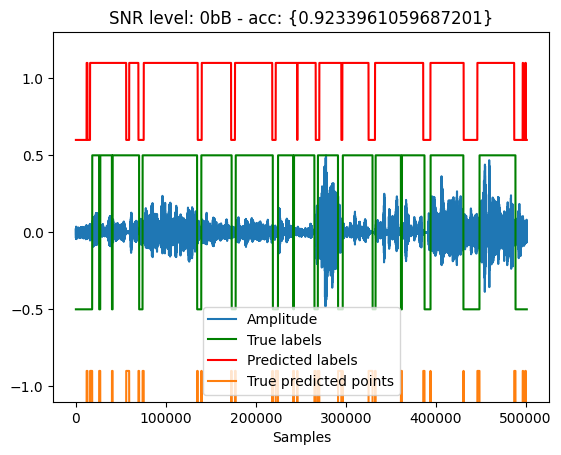

Time to execute model: 2.5534629821777344


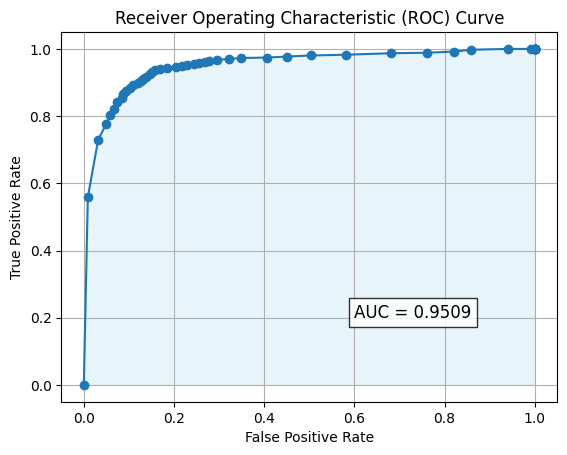

Accuracy : 0.9142948512951711
Make plot


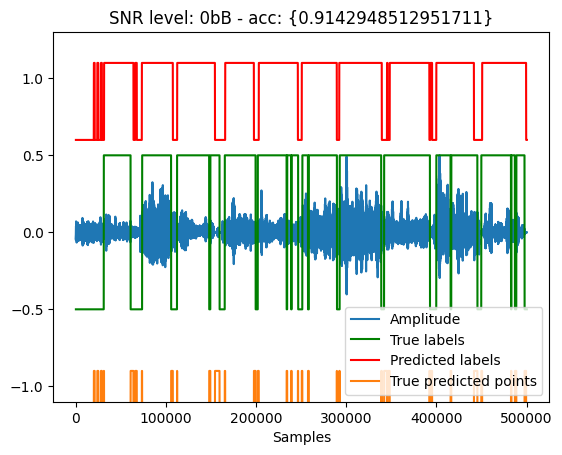

Time to execute model: 2.701282501220703


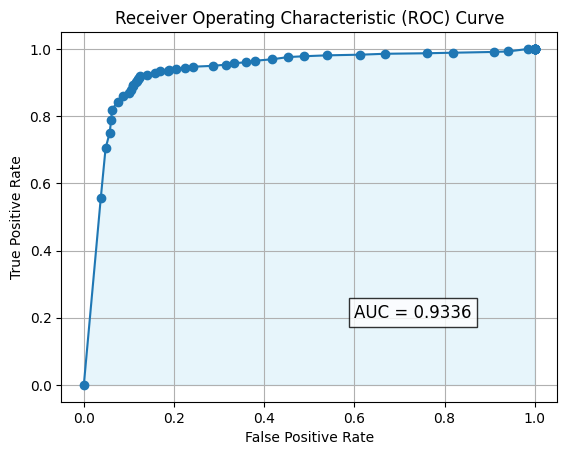

Epoch 17
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.217135
Loss DN: 4.67220938205719
Loss L: 0.02117905579507351
Accuracy of batch: 92.538886
Learning rate: 0.000033
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.225576
Loss DN: 4.695878744125366
Loss L: 0.02117905765771866
Accuracy of batch: 92.143847
Learning rate: 0.000033
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.210955
Loss DN: 4.640335321426392
Loss L: 0.02117941714823246
Accuracy of batch: 92.880601
Learning rate: 0.000033
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.244270
Loss DN: 4.822222113609314
Loss L: 0.02117927372455597
Accuracy of batch: 92.216257
Learning rate: 0.000033
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.218346
Loss DN: 4.777632236480713
Loss L: 0.02117922715842724
Accuracy of batch: 92.815557
Learning rat

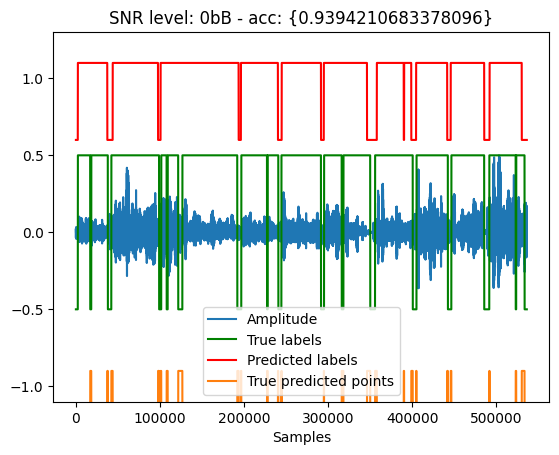

Time to execute model: 3.402233123779297


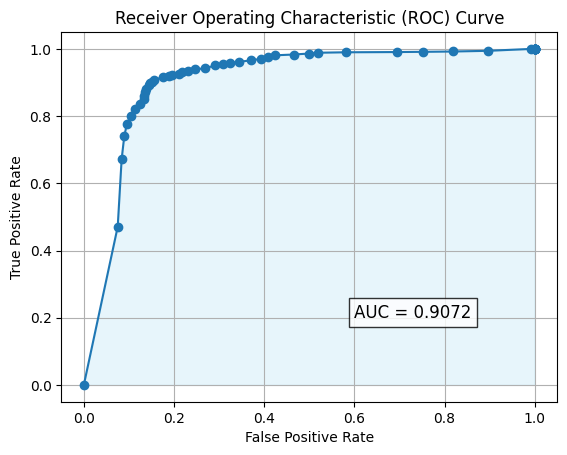

Accuracy : 0.929559748427673
Make plot


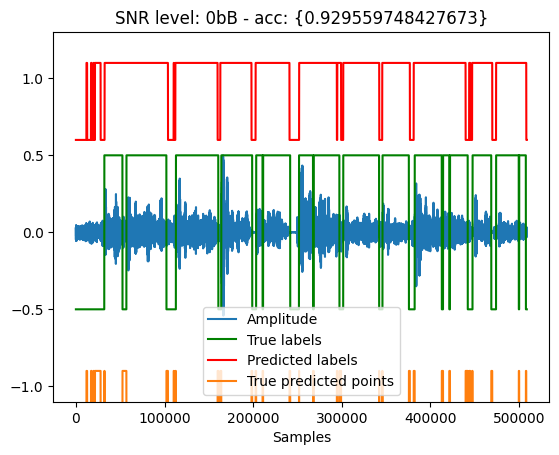

Time to execute model: 4.737377166748047


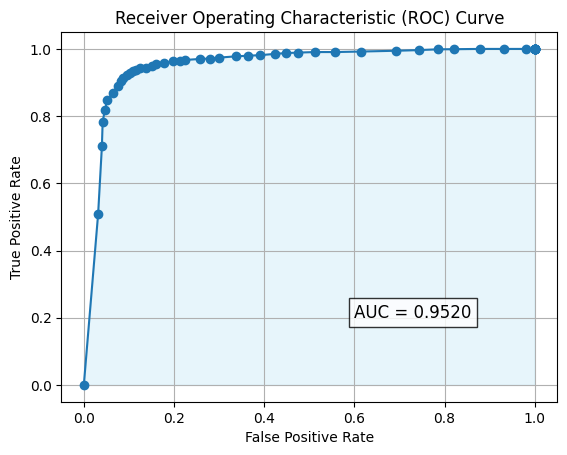

Accuracy : 0.9331909701037218
Make plot


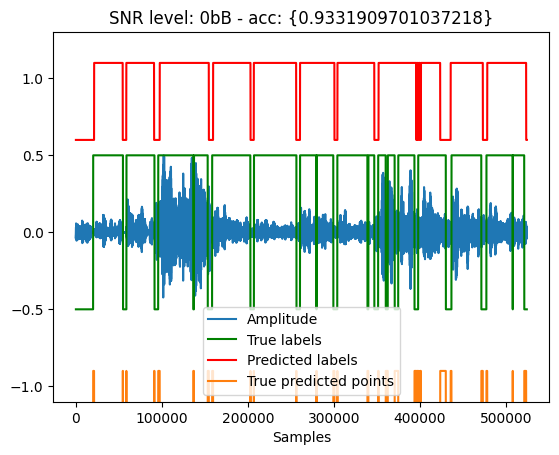

Time to execute model: 2.6121139526367188


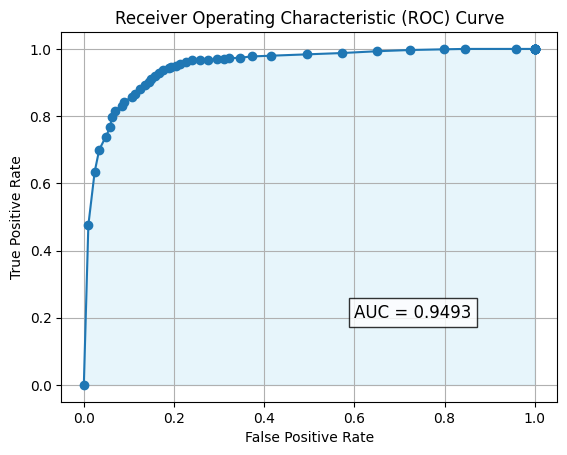

Epoch 18
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.217051
Loss DN: 4.654741883277893
Loss L: 0.021181048825383186
Accuracy of batch: 92.529539
Learning rate: 0.000023
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.246851
Loss DN: 4.6814775466918945
Loss L: 0.021181343123316765
Accuracy of batch: 91.181512
Learning rate: 0.000023
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.226479
Loss DN: 4.704065680503845
Loss L: 0.021181141957640648
Accuracy of batch: 92.042726
Learning rate: 0.000023
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.235463
Loss DN: 4.711650967597961
Loss L: 0.02118094637989998
Accuracy of batch: 91.768572
Learning rate: 0.000023
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.208203
Loss DN: 4.603589653968811
Loss L: 0.02118106558918953
Accuracy of batch: 93.597690
Learnin

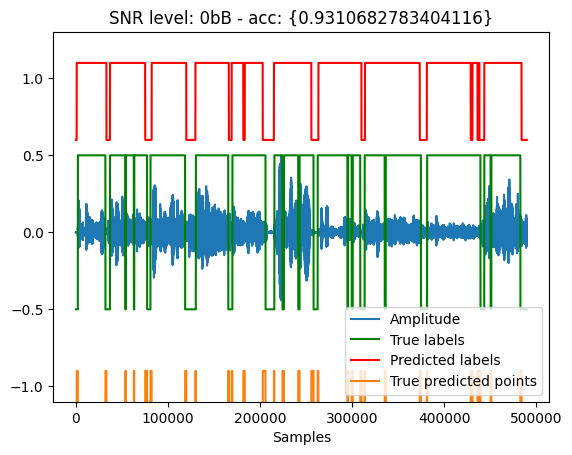

Time to execute model: 2.270936965942383


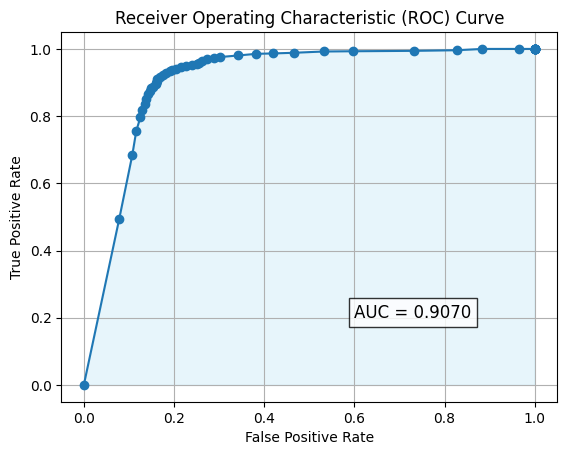

Accuracy : 0.9171402931498653
Make plot


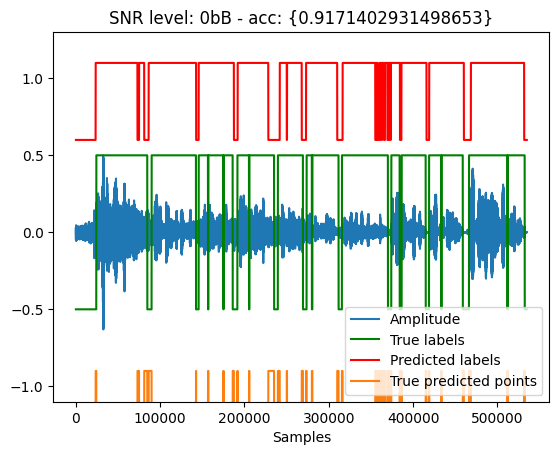

Time to execute model: 2.268552780151367


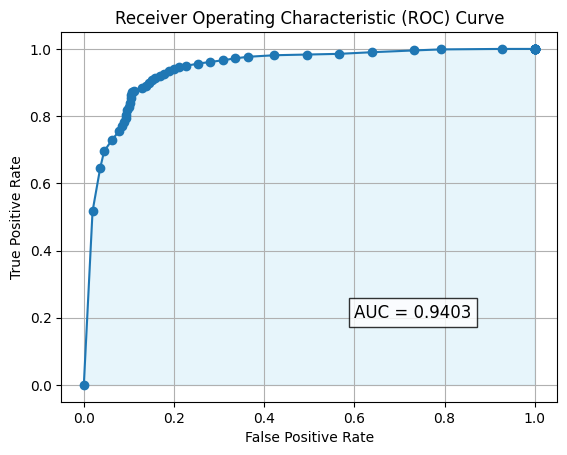

Accuracy : 0.9263294422827497
Make plot


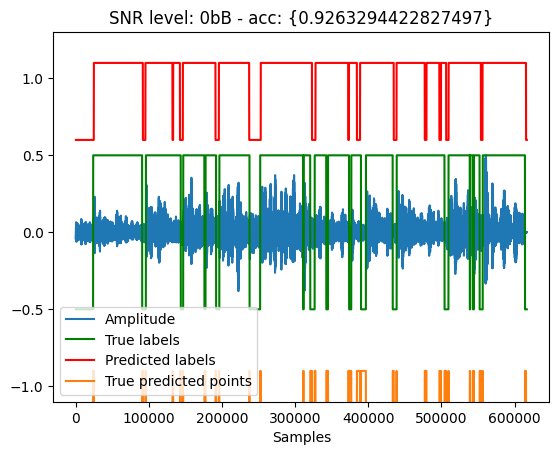

Time to execute model: 2.4781227111816406


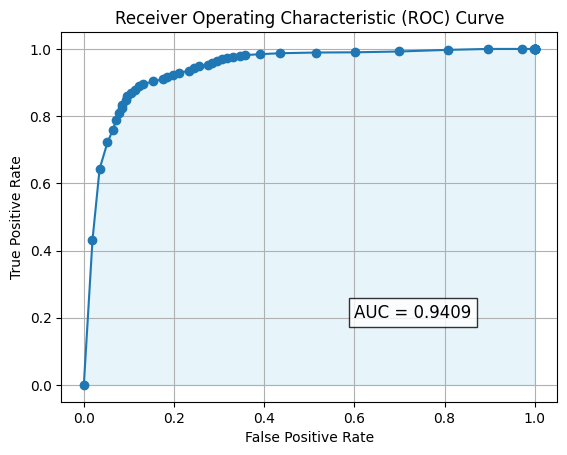

Epoch 19
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.184080
Loss DN: 4.69257390499115
Loss L: 0.021182475611567497
Accuracy of batch: 94.040568
Learning rate: 0.000016
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.186180
Loss DN: 4.664860486984253
Loss L: 0.021182598546147346
Accuracy of batch: 93.363263
Learning rate: 0.000016
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.214807
Loss DN: 4.730683445930481
Loss L: 0.021182650700211525
Accuracy of batch: 91.885651
Learning rate: 0.000016
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.211395
Loss DN: 4.6759339570999146
Loss L: 0.02118273638188839
Accuracy of batch: 92.685052
Learning rate: 0.000016
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.237721
Loss DN: 4.700953483581543
Loss L: 0.02118266187608242
Accuracy of batch: 91.717509
Learning

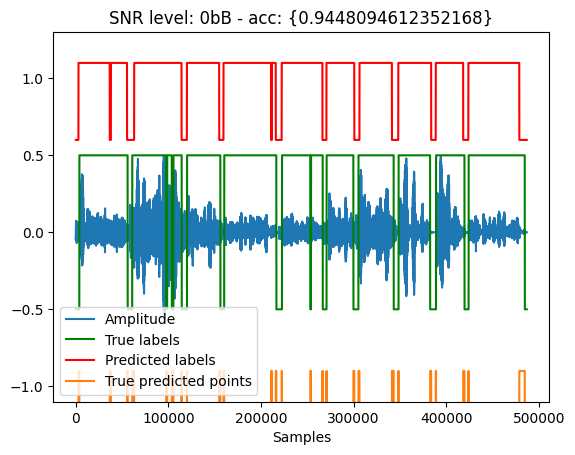

Time to execute model: 3.0770301818847656


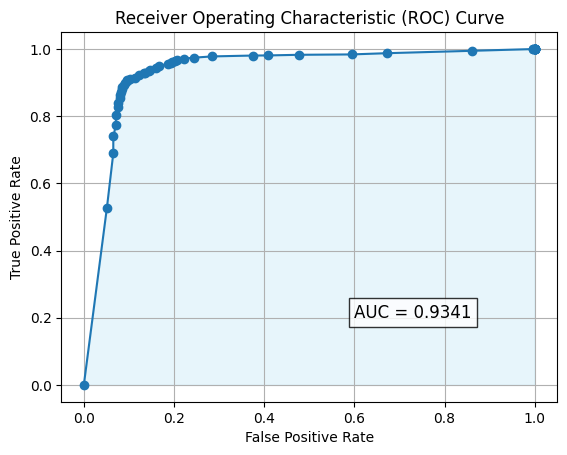

Accuracy : 0.9185897435897435
Make plot


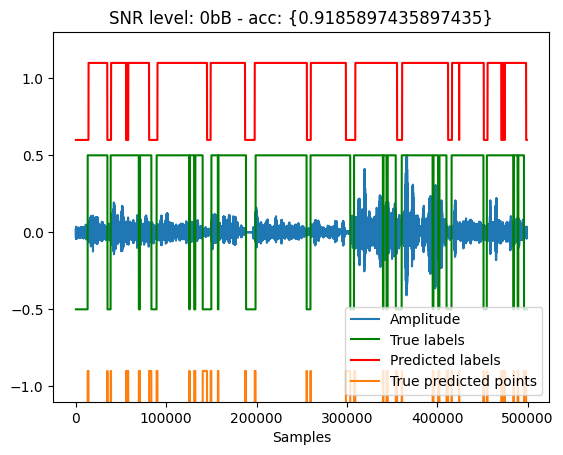

Time to execute model: 2.353191375732422


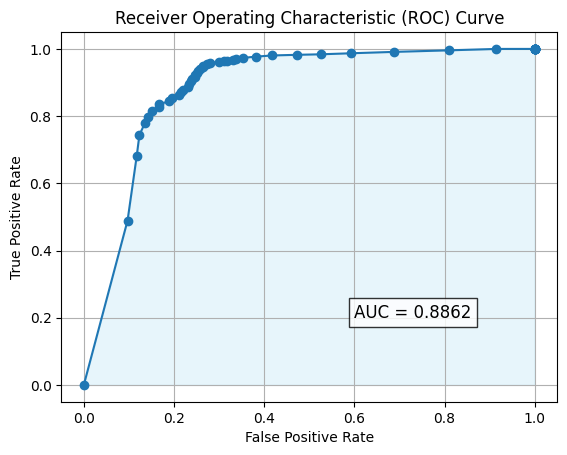

Accuracy : 0.931164681963404
Make plot


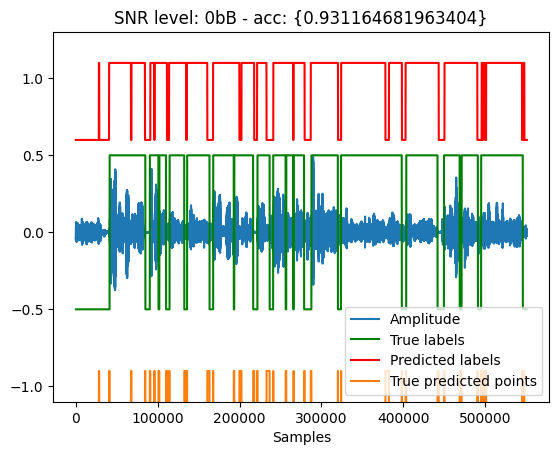

Time to execute model: 3.9300918579101562


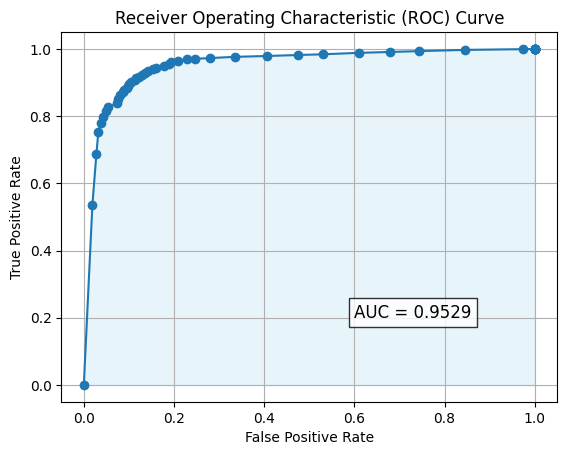

Epoch 20
--------------TRAIN-----------------
Current file/Number of files: [   30/ 4620]
loss VAD: 0.259322
Loss DN: 4.668188095092773
Loss L: 0.021184489130973816
Accuracy of batch: 89.232976
Learning rate: 0.000011
Learning rate DN: 0.000000

Current file/Number of files: [   60/ 4620]
loss VAD: 0.236786
Loss DN: 4.726085782051086
Loss L: 0.021184293553233147
Accuracy of batch: 92.863551
Learning rate: 0.000011
Learning rate DN: 0.000000

Current file/Number of files: [   90/ 4620]
loss VAD: 0.185778
Loss DN: 4.751258492469788
Loss L: 0.02118433453142643
Accuracy of batch: 93.972647
Learning rate: 0.000011
Learning rate DN: 0.000000

Current file/Number of files: [  120/ 4620]
loss VAD: 0.216279
Loss DN: 4.697583913803101
Loss L: 0.021184487268328667
Accuracy of batch: 92.555162
Learning rate: 0.000011
Learning rate DN: 0.000000

Current file/Number of files: [  150/ 4620]
loss VAD: 0.201112
Loss DN: 4.626381516456604
Loss L: 0.0211844090372324
Accuracy of batch: 93.344854
Learning 

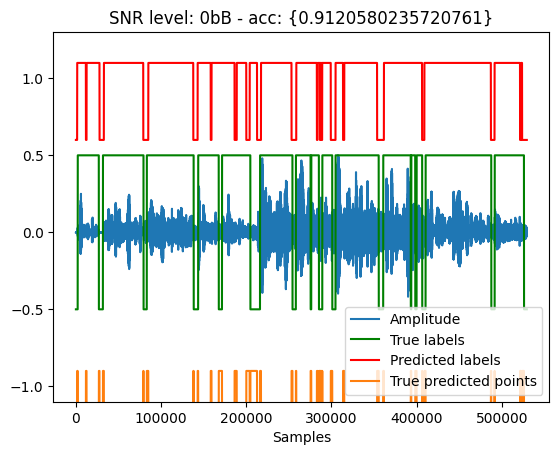

Time to execute model: 2.1905899047851562


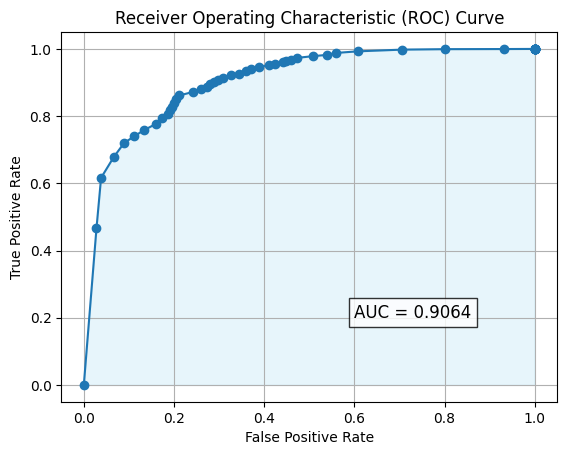

Accuracy : 0.9296875
Make plot


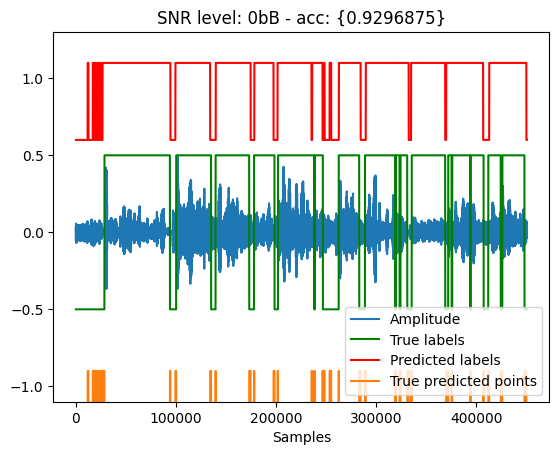

Time to execute model: 3.374814987182617


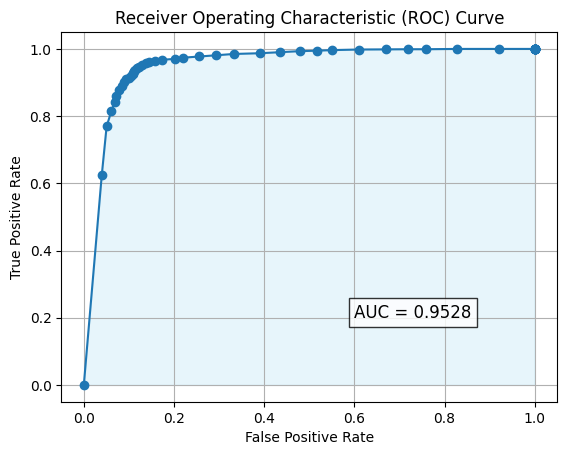

Accuracy : 0.920368542283646
Make plot


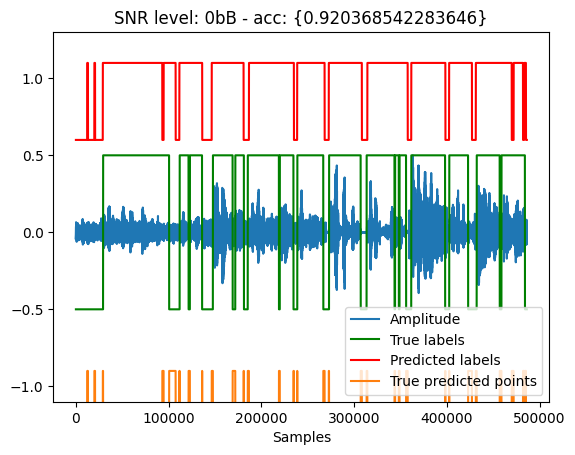

Time to execute model: 2.660512924194336


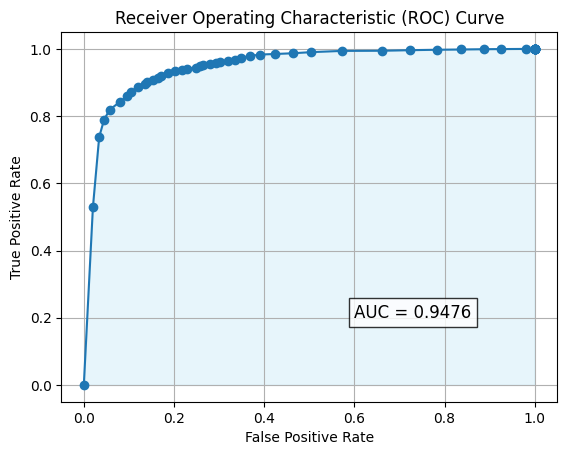

In [ ]:
pretrained = True
continue_train = False

path_to_model = ""

if(pretrained):
  load_model(path_to_model)

else:
  for t in range(training_epochs):
      run_train(t)
      run_test(t)